In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier, 
                              HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

C:\Users\Sourav\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data-1.csv")

In [3]:
# lowercase all columns
df=df.drop('id', 1)
df.columns = df.columns.str.lower()
df.head()

,gender,age,hypertension,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.shape

(5110, 10)

In [5]:
# checking null values
df.isna().sum()

gender                 0
age                    0
hypertension           0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   ever_married       5110 non-null   object 
 4   work_type          5110 non-null   object 
 5   residence_type     5110 non-null   object 
 6   avg_glucose_level  5110 non-null   float64
 7   bmi                4909 non-null   float64
 8   smoking_status     5110 non-null   object 
 9   stroke             5110 non-null   int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 399.3+ KB


In [7]:
# bmi value gender wise

df.groupby(['gender'])['bmi'].agg(['mean', 'median'])

,mean,median
gender,,
Female,29.065758,27.8
Male,28.647936,28.4
Other,22.400000,22.4


In [8]:
# filling all null values with their gender respective median values

df.bmi[df.gender=='Female'] = df.bmi[df.gender=='Female'].fillna(27.8)
df.bmi[df.gender=='Male'] = df.bmi[df.gender=='Male'].fillna(28.4)
df.bmi[df.gender=='Other'] = df.bmi[df.gender=='Other'].fillna(22.4)

In [9]:
df.isna().sum().sum()

0

In [10]:
categorical_cols = ['gender', 'hypertension', 
                    'ever_married', 'work_type', 'residence_type', 
                    'smoking_status', 'stroke']

numerical_cols = ['age', 'avg_glucose_level', 'bmi']

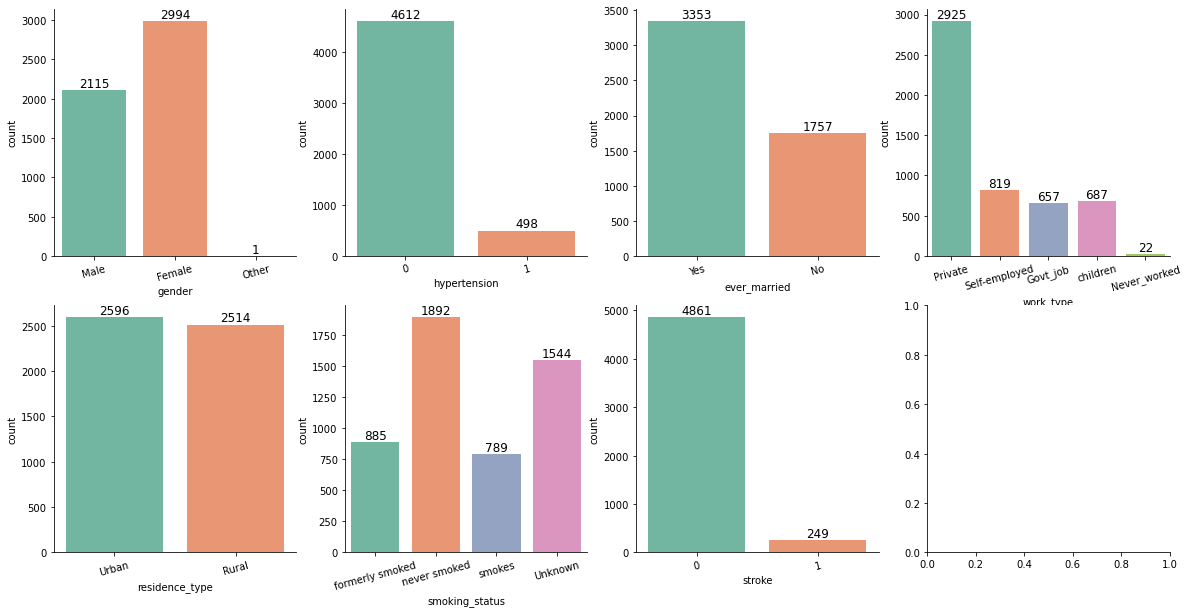

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = np.ravel(axs)

for i, col in enumerate(categorical_cols):
    plt.sca(axs[i])
    g = sns.countplot(data=df, x=col, palette="Set2")
    for rect in g.patches:
        x, y = rect.get_x(), rect.get_y()
        h, w = rect.get_height(), rect.get_width()
        plt.annotate(f"{h}", (x+w/2, h), ha='center', va='bottom', fontsize=12, color='k')

    plt.xticks(rotation=15)

plt.show()

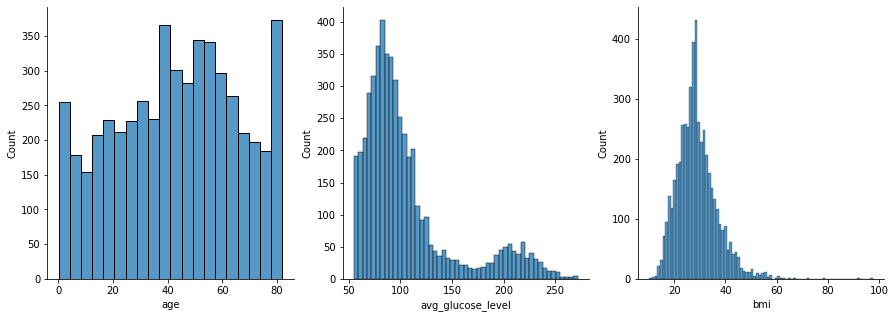

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs = np.ravel(axs)

for i, col in enumerate(numerical_cols):
    plt.sca(axs[i])
    sns.histplot(data=df, x=col, palette='Set2')

plt.show()

In [13]:
# dropping bmi outliers

df = df.loc[~(df.bmi>60)]
df.shape

(5097, 10)

In [14]:
# since "Other" gender is only one instance in the data so let's drop it

df = df.loc[~(df.gender=="Other")]

In [15]:
df.shape

(5096, 10)

In [16]:
gender_map = {'Female':0, 'Male':1}
ever_married_map = {'Yes':1, 'No':0}
residence_type_map = {'Rural':0, 'Urban':1}

df.gender = df.gender.map(gender_map)
df.ever_married = df.ever_married.map(ever_married_map)
df.residence_type = df.residence_type.map(residence_type_map)

In [17]:
X, y = df.drop('stroke', 1), df.stroke.values

In [18]:
df.head()

,gender,age,hypertension,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,Private,1,228.69,36.6,formerly smoked,1
1,0,61.0,0,1,Self-employed,0,202.21,27.8,never smoked,1
2,1,80.0,0,1,Private,0,105.92,32.5,never smoked,1
3,0,49.0,0,1,Private,1,171.23,34.4,smokes,1
4,0,79.0,1,1,Self-employed,0,174.12,24.0,never smoked,1


In [19]:
# from numpy import where

# for label, _ in df.stroke.values:
#     row_ix = where(y == label)[0]
#     plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
# plt.legend()
# plt.show()

In [20]:
df.isna().sum()

gender               0
age                  0
hypertension         0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [21]:
X = pd.get_dummies(X, drop_first=True)

sm = SMOTE()
X, y = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=10, stratify=y)

X_train.shape, y_train.shape

((7755, 14), (7755,))

In [22]:
# scaling data

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
def show_model_results(model):
    """A simple function to show a model results"""
    print(f"{model.__class__.__name__:*^50}\n")
    model.fit(X_train_scaled, y_train)
    print(f"Train Acc.: {model.score(X_train_scaled, y_train)*100:.2f}%")
    print(f"Test Acc.: {model.score(X_test_scaled, y_test)*100:.2f}%")
    x = "Confusion Matrix"
    print(f"\n{x:*^30}\n")
    print(metrics.confusion_matrix(y_test, model.predict(X_test_scaled)))

### Logistic Regression

In [24]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
# show_model_results(log_reg)

LogisticRegression()

In [25]:
pred_lg=log_reg.predict(X_test)

In [26]:
cm = confusion_matrix(y_test,pred_lg)
print(cm)
print('Accuracy {:.2f} \nRecall: {:.2f} \nPrecision: {:.2f} \nF1-Score: {:.2f}'.format((accuracy_score(y_test,pred_lg)*100),
                                                                                       (recall_score(y_test,pred_lg)*100),
                                                                                       (precision_score(y_test,pred_lg)*100),
                                                                                       (f1_score(y_test,pred_lg)*100)))


[[831 138]
 [133 837]]
Accuracy 86.02 
Recall: 86.29 
Precision: 85.85 
F1-Score: 86.07


### KNN

In [27]:
knn_clf = KNeighborsClassifier()

# show_model_results(knn_clf)

In [28]:
random_forest = RandomForestClassifier(max_depth=11, min_samples_split=4, random_state=10)
knn_clf.fit(X_train,y_train)
# show_model_results(random_forest)

KNeighborsClassifier()

In [29]:
pred_knn=knn_clf.predict(X_test)

In [30]:
cm = confusion_matrix(y_test,pred_knn)
print(cm)
print('Accuracy {:.2f} \nRecall: {:.2f} \nPrecision: {:.2f} \nF1-Score: {:.2f}'.format((accuracy_score(y_test,pred_knn)*100),
                                                                                       (recall_score(y_test,pred_knn)*100),
                                                                                       (precision_score(y_test,pred_knn)*100),
                                                                                       (f1_score(y_test,pred_knn)*100)))


[[778 191]
 [ 19 951]]
Accuracy 89.17 
Recall: 98.04 
Precision: 83.27 
F1-Score: 90.06


### XGBoost

In [31]:
xgb_clf = XGBClassifier(random_state=10)
# show_model_results(xgb_clf)

In [32]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [33]:
params = {
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30,0.35,0.4 ] ,
    'min_child_weight': [1,2,3,4,5,6,7,8,9,10],
    'gamma': [0.5, 1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2, 5],
    'subsample': [0.2, 0.4, 0.6, 0.8,0.85, 1.0],
    'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'random_state': [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241, 4242, 4243, 4244, 4245, 4246, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4274, 4275, 4276, 4277, 4278, 4279, 4280, 4281, 4282, 4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4362, 4363, 4364, 4365, 4366, 4367, 4368, 4369, 4370, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4453, 4454, 4455, 4456, 4457, 4458, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521, 4522, 4523, 4524, 4525, 4526, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4551, 4552, 4553, 4554, 4555, 4556, 4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4565, 4566, 4567, 4568, 4569, 4570, 4571, 4572, 4573, 4574, 4575, 4576, 4577, 4578, 4579, 4580, 4581, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4591, 4592, 4593, 4594, 4595, 4596, 4597, 4598, 4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4635, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4671, 4672, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4704, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4729, 4730, 4731, 4732, 4733, 4734, 4735, 4736, 4737, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769, 4770, 4771, 4772, 4773, 4774, 4775, 4776, 4777, 4778, 4779, 4780, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039, 5040, 5041, 5042, 5043, 5044, 5045, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5065, 5066, 5067, 5068, 5069, 5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5080, 5081, 5082, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5109, 5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119, 5120, 5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131, 5132, 5133, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5152, 5153, 5154, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218, 5219, 5220, 5221, 5222, 5223, 5224, 5225, 5226, 5227, 5228, 5229, 5230, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 5240, 5241, 5242, 5243, 5244, 5245, 5246, 5247, 5248, 5249, 5250, 5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5293, 5294, 5295, 5296, 5297, 5298, 5299, 5300, 5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 5311, 5312, 5313, 5314, 5315, 5316, 5317, 5318, 5319, 5320, 5321, 5322, 5323, 5324, 5325, 5326, 5327, 5328, 5329, 5330, 5331, 5332, 5333, 5334, 5335, 5336, 5337, 5338, 5339, 5340, 5341, 5342, 5343, 5344, 5345, 5346, 5347, 5348, 5349, 5350, 5351, 5352, 5353, 5354, 5355, 5356, 5357, 5358, 5359, 5360, 5361, 5362, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371, 5372, 5373, 5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5389, 5390, 5391, 5392, 5393, 5394, 5395, 5396, 5397, 5398, 5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423, 5424, 5425, 5426, 5427, 5428, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 5436, 5437, 5438, 5439, 5440, 5441, 5442, 5443, 5444, 5445, 5446, 5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5455, 5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465, 5466, 5467, 5468, 5469, 5470, 5471, 5472, 5473, 5474, 5475, 5476, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5484, 5485, 5486, 5487, 5488, 5489, 5490, 5491, 5492, 5493, 5494, 5495, 5496, 5497, 5498, 5499, 5500, 5501, 5502, 5503, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512, 5513, 5514, 5515, 5516, 5517, 5518, 5519, 5520, 5521, 5522, 5523, 5524, 5525, 5526, 5527, 5528, 5529, 5530, 5531, 5532, 5533, 5534, 5535, 5536, 5537, 5538, 5539, 5540, 5541, 5542, 5543, 5544, 5545, 5546, 5547, 5548, 5549, 5550, 5551, 5552, 5553, 5554, 5555, 5556, 5557, 5558, 5559, 5560, 5561, 5562, 5563, 5564, 5565, 5566, 5567, 5568, 5569, 5570, 5571, 5572, 5573, 5574, 5575, 5576, 5577, 5578, 5579, 5580, 5581, 5582, 5583, 5584, 5585, 5586, 5587, 5588, 5589, 5590, 5591, 5592, 5593, 5594, 5595, 5596, 5597, 5598, 5599, 5600, 5601, 5602, 5603, 5604, 5605, 5606, 5607, 5608, 5609, 5610, 5611, 5612, 5613, 5614, 5615, 5616, 5617, 5618, 5619, 5620, 5621, 5622, 5623, 5624, 5625, 5626, 5627, 5628, 5629, 5630, 5631, 5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721, 5722, 5723, 5724, 5725, 5726, 5727, 5728, 5729, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5752, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 5762, 5763, 5764, 5765, 5766, 5767, 5768, 5769, 5770, 5771, 5772, 5773, 5774, 5775, 5776, 5777, 5778, 5779, 5780, 5781, 5782, 5783, 5784, 5785, 5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798, 5799, 5800, 5801, 5802, 5803, 5804, 5805, 5806, 5807, 5808, 5809, 5810, 5811, 5812, 5813, 5814, 5815, 5816, 5817, 5818, 5819, 5820, 5821, 5822, 5823, 5824, 5825, 5826, 5827, 5828, 5829, 5830, 5831, 5832, 5833, 5834, 5835, 5836, 5837, 5838, 5839, 5840, 5841, 5842, 5843, 5844, 5845, 5846, 5847, 5848, 5849, 5850, 5851, 5852, 5853, 5854, 5855, 5856, 5857, 5858, 5859, 5860, 5861, 5862, 5863, 5864, 5865, 5866, 5867, 5868, 5869, 5870, 5871, 5872, 5873, 5874, 5875, 5876, 5877, 5878, 5879, 5880, 5881, 5882, 5883, 5884, 5885, 5886, 5887, 5888, 5889, 5890, 5891, 5892, 5893, 5894, 5895, 5896, 5897, 5898, 5899, 5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5914, 5915, 5916, 5917, 5918, 5919, 5920, 5921, 5922, 5923, 5924, 5925, 5926, 5927, 5928, 5929, 5930, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5938, 5939, 5940, 5941, 5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951, 5952, 5953, 5954, 5955, 5956, 5957, 5958, 5959, 5960, 5961, 5962, 5963, 5964, 5965, 5966, 5967, 5968, 5969, 5970, 5971, 5972, 5973, 5974, 5975, 5976, 5977, 5978, 5979, 5980, 5981, 5982, 5983, 5984, 5985, 5986, 5987, 5988, 5989, 5990, 5991, 5992, 5993, 5994, 5995, 5996, 5997, 5998, 5999, 6000, 6001, 6002, 6003, 6004, 6005, 6006, 6007, 6008, 6009, 6010, 6011, 6012, 6013, 6014, 6015, 6016, 6017, 6018, 6019, 6020, 6021, 6022, 6023, 6024, 6025, 6026, 6027, 6028, 6029, 6030, 6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 6070, 6071, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6089, 6090, 6091, 6092, 6093, 6094, 6095, 6096, 6097, 6098, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6160, 6161, 6162, 6163, 6164, 6165, 6166, 6167, 6168, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200, 6201, 6202, 6203, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6249, 6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 6259, 6260, 6261, 6262, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6289, 6290, 6291, 6292, 6293, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6316, 6317, 6318, 6319, 6320, 6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349, 6350, 6351, 6352, 6353, 6354, 6355, 6356, 6357, 6358, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 6366, 6367, 6368, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6377, 6378, 6379, 6380, 6381, 6382, 6383, 6384, 6385, 6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6398, 6399, 6400, 6401, 6402, 6403, 6404, 6405, 6406, 6407, 6408, 6409, 6410, 6411, 6412, 6413, 6414, 6415, 6416, 6417, 6418, 6419, 6420, 6421, 6422, 6423, 6424, 6425, 6426, 6427, 6428, 6429, 6430, 6431, 6432, 6433, 6434, 6435, 6436, 6437, 6438, 6439, 6440, 6441, 6442, 6443, 6444, 6445, 6446, 6447, 6448, 6449, 6450, 6451, 6452, 6453, 6454, 6455, 6456, 6457, 6458, 6459, 6460, 6461, 6462, 6463, 6464, 6465, 6466, 6467, 6468, 6469, 6470, 6471, 6472, 6473, 6474, 6475, 6476, 6477, 6478, 6479, 6480, 6481, 6482, 6483, 6484, 6485, 6486, 6487, 6488, 6489, 6490, 6491, 6492, 6493, 6494, 6495, 6496, 6497, 6498, 6499, 6500, 6501, 6502, 6503, 6504, 6505, 6506, 6507, 6508, 6509, 6510, 6511, 6512, 6513, 6514, 6515, 6516, 6517, 6518, 6519, 6520, 6521, 6522, 6523, 6524, 6525, 6526, 6527, 6528, 6529, 6530, 6531, 6532, 6533, 6534, 6535, 6536, 6537, 6538, 6539, 6540, 6541, 6542, 6543, 6544, 6545, 6546, 6547, 6548, 6549, 6550, 6551, 6552, 6553, 6554, 6555, 6556, 6557, 6558, 6559, 6560, 6561, 6562, 6563, 6564, 6565, 6566, 6567, 6568, 6569, 6570, 6571, 6572, 6573, 6574, 6575, 6576, 6577, 6578, 6579, 6580, 6581, 6582, 6583, 6584, 6585, 6586, 6587, 6588, 6589, 6590, 6591, 6592, 6593, 6594, 6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6640, 6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738, 6739, 6740, 6741, 6742, 6743, 6744, 6745, 6746, 6747, 6748, 6749, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 6798, 6799, 6800, 6801, 6802, 6803, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6898, 6899, 6900, 6901, 6902, 6903, 6904, 6905, 6906, 6907, 6908, 6909, 6910, 6911, 6912, 6913, 6914, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 6923, 6924, 6925, 6926, 6927, 6928, 6929, 6930, 6931, 6932, 6933, 6934, 6935, 6936, 6937, 6938, 6939, 6940, 6941, 6942, 6943, 6944, 6945, 6946, 6947, 6948, 6949, 6950, 6951, 6952, 6953, 6954, 6955, 6956, 6957, 6958, 6959, 6960, 6961, 6962, 6963, 6964, 6965, 6966, 6967, 6968, 6969, 6970, 6971, 6972, 6973, 6974, 6975, 6976, 6977, 6978, 6979, 6980, 6981, 6982, 6983, 6984, 6985, 6986, 6987, 6988, 6989, 6990, 6991, 6992, 6993, 6994, 6995, 6996, 6997, 6998, 6999, 7000, 7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009, 7010, 7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7019, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7074, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7082, 7083, 7084, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7130, 7131, 7132, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7141, 7142, 7143, 7144, 7145, 7146, 7147, 7148, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7163, 7164, 7165, 7166, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179, 7180, 7181, 7182, 7183, 7184, 7185, 7186, 7187, 7188, 7189, 7190, 7191, 7192, 7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7264, 7265, 7266, 7267, 7268, 7269, 7270, 7271, 7272, 7273, 7274, 7275, 7276, 7277, 7278, 7279, 7280, 7281, 7282, 7283, 7284, 7285, 7286, 7287, 7288, 7289, 7290, 7291, 7292, 7293, 7294, 7295, 7296, 7297, 7298, 7299, 7300, 7301, 7302, 7303, 7304, 7305, 7306, 7307, 7308, 7309, 7310, 7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7320, 7321, 7322, 7323, 7324, 7325, 7326, 7327, 7328, 7329, 7330, 7331, 7332, 7333, 7334, 7335, 7336, 7337, 7338, 7339, 7340, 7341, 7342, 7343, 7344, 7345, 7346, 7347, 7348, 7349, 7350, 7351, 7352, 7353, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366, 7367, 7368, 7369, 7370, 7371, 7372, 7373, 7374, 7375, 7376, 7377, 7378, 7379, 7380, 7381, 7382, 7383, 7384, 7385, 7386, 7387, 7388, 7389, 7390, 7391, 7392, 7393, 7394, 7395, 7396, 7397, 7398, 7399, 7400, 7401, 7402, 7403, 7404, 7405, 7406, 7407, 7408, 7409, 7410, 7411, 7412, 7413, 7414, 7415, 7416, 7417, 7418, 7419, 7420, 7421, 7422, 7423, 7424, 7425, 7426, 7427, 7428, 7429, 7430, 7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438, 7439, 7440, 7441, 7442, 7443, 7444, 7445, 7446, 7447, 7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7456, 7457, 7458, 7459, 7460, 7461, 7462, 7463, 7464, 7465, 7466, 7467, 7468, 7469, 7470, 7471, 7472, 7473, 7474, 7475, 7476, 7477, 7478, 7479, 7480, 7481, 7482, 7483, 7484, 7485, 7486, 7487, 7488, 7489, 7490, 7491, 7492, 7493, 7494, 7495, 7496, 7497, 7498, 7499, 7500, 7501, 7502, 7503, 7504, 7505, 7506, 7507, 7508, 7509, 7510, 7511, 7512, 7513, 7514, 7515, 7516, 7517, 7518, 7519, 7520, 7521, 7522, 7523, 7524, 7525, 7526, 7527, 7528, 7529, 7530, 7531, 7532, 7533, 7534, 7535, 7536, 7537, 7538, 7539, 7540, 7541, 7542, 7543, 7544, 7545, 7546, 7547, 7548, 7549, 7550, 7551, 7552, 7553, 7554, 7555, 7556, 7557, 7558, 7559, 7560, 7561, 7562, 7563, 7564, 7565, 7566, 7567, 7568, 7569, 7570, 7571, 7572, 7573, 7574, 7575, 7576, 7577, 7578, 7579, 7580, 7581, 7582, 7583, 7584, 7585, 7586, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599, 7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612, 7613, 7614, 7615, 7616, 7617, 7618, 7619, 7620, 7621, 7622, 7623, 7624, 7625, 7626, 7627, 7628, 7629, 7630, 7631, 7632, 7633, 7634, 7635, 7636, 7637, 7638, 7639, 7640, 7641, 7642, 7643, 7644, 7645, 7646, 7647, 7648, 7649, 7650, 7651, 7652, 7653, 7654, 7655, 7656, 7657, 7658, 7659, 7660, 7661, 7662, 7663, 7664, 7665, 7666, 7667, 7668, 7669, 7670, 7671, 7672, 7673, 7674, 7675, 7676, 7677, 7678, 7679, 7680, 7681, 7682, 7683, 7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693, 7694, 7695, 7696, 7697, 7698, 7699, 7700, 7701, 7702, 7703, 7704, 7705, 7706, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7714, 7715, 7716, 7717, 7718, 7719, 7720, 7721, 7722, 7723, 7724, 7725, 7726, 7727, 7728, 7729, 7730, 7731, 7732, 7733, 7734, 7735, 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7743, 7744, 7745, 7746, 7747, 7748, 7749, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7757, 7758, 7759, 7760, 7761, 7762, 7763, 7764, 7765, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 7773, 7774, 7775, 7776, 7777, 7778, 7779, 7780, 7781, 7782, 7783, 7784, 7785, 7786, 7787, 7788, 7789, 7790, 7791, 7792, 7793, 7794, 7795, 7796, 7797, 7798, 7799, 7800, 7801, 7802, 7803, 7804, 7805, 7806, 7807, 7808, 7809, 7810, 7811, 7812, 7813, 7814, 7815, 7816, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7848, 7849, 7850, 7851, 7852, 7853, 7854, 7855, 7856, 7857, 7858, 7859, 7860, 7861, 7862, 7863, 7864, 7865, 7866, 7867, 7868, 7869, 7870, 7871, 7872, 7873, 7874, 7875, 7876, 7877, 7878, 7879, 7880, 7881, 7882, 7883, 7884, 7885, 7886, 7887, 7888, 7889, 7890, 7891, 7892, 7893, 7894, 7895, 7896, 7897, 7898, 7899, 7900, 7901, 7902, 7903, 7904, 7905, 7906, 7907, 7908, 7909, 7910, 7911, 7912, 7913, 7914, 7915, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 7923, 7924, 7925, 7926, 7927, 7928, 7929, 7930, 7931, 7932, 7933, 7934, 7935, 7936, 7937, 7938, 7939, 7940, 7941, 7942, 7943, 7944, 7945, 7946, 7947, 7948, 7949, 7950, 7951, 7952, 7953, 7954, 7955, 7956, 7957, 7958, 7959, 7960, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7968, 7969, 7970, 7971, 7972, 7973, 7974, 7975, 7976, 7977, 7978, 7979, 7980, 7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001, 8002, 8003, 8004, 8005, 8006, 8007, 8008, 8009, 8010, 8011, 8012, 8013, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8024, 8025, 8026, 8027, 8028, 8029, 8030, 8031, 8032, 8033, 8034, 8035, 8036, 8037, 8038, 8039, 8040, 8041, 8042, 8043, 8044, 8045, 8046, 8047, 8048, 8049, 8050, 8051, 8052, 8053, 8054, 8055, 8056, 8057, 8058, 8059, 8060, 8061, 8062, 8063, 8064, 8065, 8066, 8067, 8068, 8069, 8070, 8071, 8072, 8073, 8074, 8075, 8076, 8077, 8078, 8079, 8080, 8081, 8082, 8083, 8084, 8085, 8086, 8087, 8088, 8089, 8090, 8091, 8092, 8093, 8094, 8095, 8096, 8097, 8098, 8099, 8100, 8101, 8102, 8103, 8104, 8105, 8106, 8107, 8108, 8109, 8110, 8111, 8112, 8113, 8114, 8115, 8116, 8117, 8118, 8119, 8120, 8121, 8122, 8123, 8124, 8125, 8126, 8127, 8128, 8129, 8130, 8131, 8132, 8133, 8134, 8135, 8136, 8137, 8138, 8139, 8140, 8141, 8142, 8143, 8144, 8145, 8146, 8147, 8148, 8149, 8150, 8151, 8152, 8153, 8154, 8155, 8156, 8157, 8158, 8159, 8160, 8161, 8162, 8163, 8164, 8165, 8166, 8167, 8168, 8169, 8170, 8171, 8172, 8173, 8174, 8175, 8176, 8177, 8178, 8179, 8180, 8181, 8182, 8183, 8184, 8185, 8186, 8187, 8188, 8189, 8190, 8191, 8192, 8193, 8194, 8195, 8196, 8197, 8198, 8199, 8200, 8201, 8202, 8203, 8204, 8205, 8206, 8207, 8208, 8209, 8210, 8211, 8212, 8213, 8214, 8215, 8216, 8217, 8218, 8219, 8220, 8221, 8222, 8223, 8224, 8225, 8226, 8227, 8228, 8229, 8230, 8231, 8232, 8233, 8234, 8235, 8236, 8237, 8238, 8239, 8240, 8241, 8242, 8243, 8244, 8245, 8246, 8247, 8248, 8249, 8250, 8251, 8252, 8253, 8254, 8255, 8256, 8257, 8258, 8259, 8260, 8261, 8262, 8263, 8264, 8265, 8266, 8267, 8268, 8269, 8270, 8271, 8272, 8273, 8274, 8275, 8276, 8277, 8278, 8279, 8280, 8281, 8282, 8283, 8284, 8285, 8286, 8287, 8288, 8289, 8290, 8291, 8292, 8293, 8294, 8295, 8296, 8297, 8298, 8299, 8300, 8301, 8302, 8303, 8304, 8305, 8306, 8307, 8308, 8309, 8310, 8311, 8312, 8313, 8314, 8315, 8316, 8317, 8318, 8319, 8320, 8321, 8322, 8323, 8324, 8325, 8326, 8327, 8328, 8329, 8330, 8331, 8332, 8333, 8334, 8335, 8336, 8337, 8338, 8339, 8340, 8341, 8342, 8343, 8344, 8345, 8346, 8347, 8348, 8349, 8350, 8351, 8352, 8353, 8354, 8355, 8356, 8357, 8358, 8359, 8360, 8361, 8362, 8363, 8364, 8365, 8366, 8367, 8368, 8369, 8370, 8371, 8372, 8373, 8374, 8375, 8376, 8377, 8378, 8379, 8380, 8381, 8382, 8383, 8384, 8385, 8386, 8387, 8388, 8389, 8390, 8391, 8392, 8393, 8394, 8395, 8396, 8397, 8398, 8399, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408, 8409, 8410, 8411, 8412, 8413, 8414, 8415, 8416, 8417, 8418, 8419, 8420, 8421, 8422, 8423, 8424, 8425, 8426, 8427, 8428, 8429, 8430, 8431, 8432, 8433, 8434, 8435, 8436, 8437, 8438, 8439, 8440, 8441, 8442, 8443, 8444, 8445, 8446, 8447, 8448, 8449, 8450, 8451, 8452, 8453, 8454, 8455, 8456, 8457, 8458, 8459, 8460, 8461, 8462, 8463, 8464, 8465, 8466, 8467, 8468, 8469, 8470, 8471, 8472, 8473, 8474, 8475, 8476, 8477, 8478, 8479, 8480, 8481, 8482, 8483, 8484, 8485, 8486, 8487, 8488, 8489, 8490, 8491, 8492, 8493, 8494, 8495, 8496, 8497, 8498, 8499, 8500, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8509, 8510, 8511, 8512, 8513, 8514, 8515, 8516, 8517, 8518, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8528, 8529, 8530, 8531, 8532, 8533, 8534, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542, 8543, 8544, 8545, 8546, 8547, 8548, 8549, 8550, 8551, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8559, 8560, 8561, 8562, 8563, 8564, 8565, 8566, 8567, 8568, 8569, 8570, 8571, 8572, 8573, 8574, 8575, 8576, 8577, 8578, 8579, 8580, 8581, 8582, 8583, 8584, 8585, 8586, 8587, 8588, 8589, 8590, 8591, 8592, 8593, 8594, 8595, 8596, 8597, 8598, 8599, 8600, 8601, 8602, 8603, 8604, 8605, 8606, 8607, 8608, 8609, 8610, 8611, 8612, 8613, 8614, 8615, 8616, 8617, 8618, 8619, 8620, 8621, 8622, 8623, 8624, 8625, 8626, 8627, 8628, 8629, 8630, 8631, 8632, 8633, 8634, 8635, 8636, 8637, 8638, 8639, 8640, 8641, 8642, 8643, 8644, 8645, 8646, 8647, 8648, 8649, 8650, 8651, 8652, 8653, 8654, 8655, 8656, 8657, 8658, 8659, 8660, 8661, 8662, 8663, 8664, 8665, 8666, 8667, 8668, 8669, 8670, 8671, 8672, 8673, 8674, 8675, 8676, 8677, 8678, 8679, 8680, 8681, 8682, 8683, 8684, 8685, 8686, 8687, 8688, 8689, 8690, 8691, 8692, 8693, 8694, 8695, 8696, 8697, 8698, 8699, 8700, 8701, 8702, 8703, 8704, 8705, 8706, 8707, 8708, 8709, 8710, 8711, 8712, 8713, 8714, 8715, 8716, 8717, 8718, 8719, 8720, 8721, 8722, 8723, 8724, 8725, 8726, 8727, 8728, 8729, 8730, 8731, 8732, 8733, 8734, 8735, 8736, 8737, 8738, 8739, 8740, 8741, 8742, 8743, 8744, 8745, 8746, 8747, 8748, 8749, 8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760, 8761, 8762, 8763, 8764, 8765, 8766, 8767, 8768, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8799, 8800, 8801, 8802, 8803, 8804, 8805, 8806, 8807, 8808, 8809, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8817, 8818, 8819, 8820, 8821, 8822, 8823, 8824, 8825, 8826, 8827, 8828, 8829, 8830, 8831, 8832, 8833, 8834, 8835, 8836, 8837, 8838, 8839, 8840, 8841, 8842, 8843, 8844, 8845, 8846, 8847, 8848, 8849, 8850, 8851, 8852, 8853, 8854, 8855, 8856, 8857, 8858, 8859, 8860, 8861, 8862, 8863, 8864, 8865, 8866, 8867, 8868, 8869, 8870, 8871, 8872, 8873, 8874, 8875, 8876, 8877, 8878, 8879, 8880, 8881, 8882, 8883, 8884, 8885, 8886, 8887, 8888, 8889, 8890, 8891, 8892, 8893, 8894, 8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8905, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8913, 8914, 8915, 8916, 8917, 8918, 8919, 8920, 8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928, 8929, 8930, 8931, 8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8940, 8941, 8942, 8943, 8944, 8945, 8946, 8947, 8948, 8949, 8950, 8951, 8952, 8953, 8954, 8955, 8956, 8957, 8958, 8959, 8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967, 8968, 8969, 8970, 8971, 8972, 8973, 8974, 8975, 8976, 8977, 8978, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8986, 8987, 8988, 8989, 8990, 8991, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999, 9000, 9001, 9002, 9003, 9004, 9005, 9006, 9007, 9008, 9009, 9010, 9011, 9012, 9013, 9014, 9015, 9016, 9017, 9018, 9019, 9020, 9021, 9022, 9023, 9024, 9025, 9026, 9027, 9028, 9029, 9030, 9031, 9032, 9033, 9034, 9035, 9036, 9037, 9038, 9039, 9040, 9041, 9042, 9043, 9044, 9045, 9046, 9047, 9048, 9049, 9050, 9051, 9052, 9053, 9054, 9055, 9056, 9057, 9058, 9059, 9060, 9061, 9062, 9063, 9064, 9065, 9066, 9067, 9068, 9069, 9070, 9071, 9072, 9073, 9074, 9075, 9076, 9077, 9078, 9079, 9080, 9081, 9082, 9083, 9084, 9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9093, 9094, 9095, 9096, 9097, 9098, 9099, 9100, 9101, 9102, 9103, 9104, 9105, 9106, 9107, 9108, 9109, 9110, 9111, 9112, 9113, 9114, 9115, 9116, 9117, 9118, 9119, 9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127, 9128, 9129, 9130, 9131, 9132, 9133, 9134, 9135, 9136, 9137, 9138, 9139, 9140, 9141, 9142, 9143, 9144, 9145, 9146, 9147, 9148, 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9156, 9157, 9158, 9159, 9160, 9161, 9162, 9163, 9164, 9165, 9166, 9167, 9168, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9184, 9185, 9186, 9187, 9188, 9189, 9190, 9191, 9192, 9193, 9194, 9195, 9196, 9197, 9198, 9199, 9200, 9201, 9202, 9203, 9204, 9205, 9206, 9207, 9208, 9209, 9210, 9211, 9212, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223, 9224, 9225, 9226, 9227, 9228, 9229, 9230, 9231, 9232, 9233, 9234, 9235, 9236, 9237, 9238, 9239, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271, 9272, 9273, 9274, 9275, 9276, 9277, 9278, 9279, 9280, 9281, 9282, 9283, 9284, 9285, 9286, 9287, 9288, 9289, 9290, 9291, 9292, 9293, 9294, 9295, 9296, 9297, 9298, 9299, 9300, 9301, 9302, 9303, 9304, 9305, 9306, 9307, 9308, 9309, 9310, 9311, 9312, 9313, 9314, 9315, 9316, 9317, 9318, 9319, 9320, 9321, 9322, 9323, 9324, 9325, 9326, 9327, 9328, 9329, 9330, 9331, 9332, 9333, 9334, 9335, 9336, 9337, 9338, 9339, 9340, 9341, 9342, 9343, 9344, 9345, 9346, 9347, 9348, 9349, 9350, 9351, 9352, 9353, 9354, 9355, 9356, 9357, 9358, 9359, 9360, 9361, 9362, 9363, 9364, 9365, 9366, 9367, 9368, 9369, 9370, 9371, 9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381, 9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391, 9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9409, 9410, 9411, 9412, 9413, 9414, 9415, 9416, 9417, 9418, 9419, 9420, 9421, 9422, 9423, 9424, 9425, 9426, 9427, 9428, 9429, 9430, 9431, 9432, 9433, 9434, 9435, 9436, 9437, 9438, 9439, 9440, 9441, 9442, 9443, 9444, 9445, 9446, 9447, 9448, 9449, 9450, 9451, 9452, 9453, 9454, 9455, 9456, 9457, 9458, 9459, 9460, 9461, 9462, 9463, 9464, 9465, 9466, 9467, 9468, 9469, 9470, 9471, 9472, 9473, 9474, 9475, 9476, 9477, 9478, 9479, 9480, 9481, 9482, 9483, 9484, 9485, 9486, 9487, 9488, 9489, 9490, 9491, 9492, 9493, 9494, 9495, 9496, 9497, 9498, 9499, 9500, 9501, 9502, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9510, 9511, 9512, 9513, 9514, 9515, 9516, 9517, 9518, 9519, 9520, 9521, 9522, 9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9531, 9532, 9533, 9534, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555, 9556, 9557, 9558, 9559, 9560, 9561, 9562, 9563, 9564, 9565, 9566, 9567, 9568, 9569, 9570, 9571, 9572, 9573, 9574, 9575, 9576, 9577, 9578, 9579, 9580, 9581, 9582, 9583, 9584, 9585, 9586, 9587, 9588, 9589, 9590, 9591, 9592, 9593, 9594, 9595, 9596, 9597, 9598, 9599, 9600, 9601, 9602, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9624, 9625, 9626, 9627, 9628, 9629, 9630, 9631, 9632, 9633, 9634, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9642, 9643, 9644, 9645, 9646, 9647, 9648, 9649, 9650, 9651, 9652, 9653, 9654, 9655, 9656, 9657, 9658, 9659, 9660, 9661, 9662, 9663, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9671, 9672, 9673, 9674, 9675, 9676, 9677, 9678, 9679, 9680, 9681, 9682, 9683, 9684, 9685, 9686, 9687, 9688, 9689, 9690, 9691, 9692, 9693, 9694, 9695, 9696, 9697, 9698, 9699, 9700, 9701, 9702, 9703, 9704, 9705, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9714, 9715, 9716, 9717, 9718, 9719, 9720, 9721, 9722, 9723, 9724, 9725, 9726, 9727, 9728, 9729, 9730, 9731, 9732, 9733, 9734, 9735, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9743, 9744, 9745, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 9912, 9913, 9914, 9915, 9916, 9917, 9918, 9919, 9920, 9921, 9922, 9923, 9924, 9925, 9926, 9927, 9928, 9929, 9930, 9931, 9932, 9933, 9934, 9935, 9936, 9937, 9938, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946, 9947, 9948, 9949, 9950, 9951, 9952, 9953, 9954, 9955, 9956, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966, 9967, 9968, 9969, 9970, 9971, 9972, 9973, 9974, 9975, 9976, 9977, 9978, 9979, 9980, 9981, 9982, 9983, 9984, 9985, 9986, 9987, 9988, 9989, 9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067, 10068, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083, 10084, 10085, 10086, 10087, 10088, 10089, 10090, 10091, 10092, 10093, 10094, 10095, 10096, 10097, 10098, 10099, 10100, 10101, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10118, 10119, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10127, 10128, 10129, 10130, 10131, 10132, 10133, 10134, 10135, 10136, 10137, 10138, 10139, 10140, 10141, 10142, 10143, 10144, 10145, 10146, 10147, 10148, 10149, 10150, 10151, 10152, 10153, 10154, 10155, 10156, 10157, 10158, 10159, 10160, 10161, 10162, 10163, 10164, 10165, 10166, 10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10177, 10178, 10179, 10180, 10181, 10182, 10183, 10184, 10185, 10186, 10187, 10188, 10189, 10190, 10191, 10192, 10193, 10194, 10195, 10196, 10197, 10198, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206, 10207, 10208, 10209, 10210, 10211, 10212, 10213, 10214, 10215, 10216, 10217, 10218, 10219, 10220, 10221, 10222, 10223, 10224, 10225, 10226, 10227, 10228, 10229, 10230, 10231, 10232, 10233, 10234, 10235, 10236, 10237, 10238, 10239, 10240, 10241, 10242, 10243, 10244, 10245, 10246, 10247, 10248, 10249, 10250, 10251, 10252, 10253, 10254, 10255, 10256, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10266, 10267, 10268, 10269, 10270, 10271, 10272, 10273, 10274, 10275, 10276, 10277, 10278, 10279, 10280, 10281, 10282, 10283, 10284, 10285, 10286, 10287, 10288, 10289, 10290, 10291, 10292, 10293, 10294, 10295, 10296, 10297, 10298, 10299, 10300, 10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311, 10312, 10313, 10314, 10315, 10316, 10317, 10318, 10319, 10320, 10321, 10322, 10323, 10324, 10325, 10326, 10327, 10328, 10329, 10330, 10331, 10332, 10333, 10334, 10335, 10336, 10337, 10338, 10339, 10340, 10341, 10342, 10343, 10344, 10345, 10346, 10347, 10348, 10349, 10350, 10351, 10352, 10353, 10354, 10355, 10356, 10357, 10358, 10359, 10360, 10361, 10362, 10363, 10364, 10365, 10366, 10367, 10368, 10369, 10370, 10371, 10372, 10373, 10374, 10375, 10376, 10377, 10378, 10379, 10380, 10381, 10382, 10383, 10384, 10385, 10386, 10387, 10388, 10389, 10390, 10391, 10392, 10393, 10394, 10395, 10396, 10397, 10398, 10399, 10400, 10401, 10402, 10403, 10404, 10405, 10406, 10407, 10408, 10409, 10410, 10411, 10412, 10413, 10414, 10415, 10416, 10417, 10418, 10419, 10420, 10421, 10422, 10423, 10424, 10425, 10426, 10427, 10428, 10429, 10430, 10431, 10432, 10433, 10434, 10435, 10436, 10437, 10438, 10439, 10440, 10441, 10442, 10443, 10444, 10445, 10446, 10447, 10448, 10449, 10450, 10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469, 10470, 10471, 10472, 10473, 10474, 10475, 10476, 10477, 10478, 10479, 10480, 10481, 10482, 10483, 10484, 10485, 10486, 10487, 10488, 10489, 10490, 10491, 10492, 10493, 10494, 10495, 10496, 10497, 10498, 10499, 10500, 10501, 10502, 10503, 10504, 10505, 10506, 10507, 10508, 10509, 10510, 10511, 10512, 10513, 10514, 10515, 10516, 10517, 10518, 10519, 10520, 10521, 10522, 10523, 10524, 10525, 10526, 10527, 10528, 10529, 10530, 10531, 10532, 10533, 10534, 10535, 10536, 10537, 10538, 10539, 10540, 10541, 10542, 10543, 10544, 10545, 10546, 10547, 10548, 10549, 10550, 10551, 10552, 10553, 10554, 10555, 10556, 10557, 10558, 10559, 10560, 10561, 10562, 10563, 10564, 10565, 10566, 10567, 10568, 10569, 10570, 10571, 10572, 10573, 10574, 10575, 10576, 10577, 10578, 10579, 10580, 10581, 10582, 10583, 10584, 10585, 10586, 10587, 10588, 10589, 10590, 10591, 10592, 10593, 10594, 10595, 10596, 10597, 10598, 10599, 10600, 10601, 10602, 10603, 10604, 10605, 10606, 10607, 10608, 10609, 10610, 10611, 10612, 10613, 10614, 10615, 10616, 10617, 10618, 10619, 10620, 10621, 10622, 10623, 10624, 10625, 10626, 10627, 10628, 10629, 10630, 10631, 10632, 10633, 10634, 10635, 10636, 10637, 10638, 10639, 10640, 10641, 10642, 10643, 10644, 10645, 10646, 10647, 10648, 10649, 10650, 10651, 10652, 10653, 10654, 10655, 10656, 10657, 10658, 10659, 10660, 10661, 10662, 10663, 10664, 10665, 10666, 10667, 10668, 10669, 10670, 10671, 10672, 10673, 10674, 10675, 10676, 10677, 10678, 10679, 10680, 10681, 10682, 10683, 10684, 10685, 10686, 10687, 10688, 10689, 10690, 10691, 10692, 10693, 10694, 10695, 10696, 10697, 10698, 10699, 10700, 10701, 10702, 10703, 10704, 10705, 10706, 10707, 10708, 10709, 10710, 10711, 10712, 10713, 10714, 10715, 10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723, 10724, 10725, 10726, 10727, 10728, 10729, 10730, 10731, 10732, 10733, 10734, 10735, 10736, 10737, 10738, 10739, 10740, 10741, 10742, 10743, 10744, 10745, 10746, 10747, 10748, 10749, 10750, 10751, 10752, 10753, 10754, 10755, 10756, 10757, 10758, 10759, 10760, 10761, 10762, 10763, 10764, 10765, 10766, 10767, 10768, 10769, 10770, 10771, 10772, 10773, 10774, 10775, 10776, 10777, 10778, 10779, 10780, 10781, 10782, 10783, 10784, 10785, 10786, 10787, 10788, 10789, 10790, 10791, 10792, 10793, 10794, 10795, 10796, 10797, 10798, 10799, 10800, 10801, 10802, 10803, 10804, 10805, 10806, 10807, 10808, 10809, 10810, 10811, 10812, 10813, 10814, 10815, 10816, 10817, 10818, 10819, 10820, 10821, 10822, 10823, 10824, 10825, 10826, 10827, 10828, 10829, 10830, 10831, 10832, 10833, 10834, 10835, 10836, 10837, 10838, 10839, 10840, 10841, 10842, 10843, 10844, 10845, 10846, 10847, 10848, 10849, 10850, 10851, 10852, 10853, 10854, 10855, 10856, 10857, 10858, 10859, 10860, 10861, 10862, 10863, 10864, 10865, 10866, 10867, 10868, 10869, 10870, 10871, 10872, 10873, 10874, 10875, 10876, 10877, 10878, 10879, 10880, 10881, 10882, 10883, 10884, 10885, 10886, 10887, 10888, 10889, 10890, 10891, 10892, 10893, 10894, 10895, 10896, 10897, 10898, 10899, 10900, 10901, 10902, 10903, 10904, 10905, 10906, 10907, 10908, 10909, 10910, 10911, 10912, 10913, 10914, 10915, 10916, 10917, 10918, 10919, 10920, 10921, 10922, 10923, 10924, 10925, 10926, 10927, 10928, 10929, 10930, 10931, 10932, 10933, 10934, 10935, 10936, 10937, 10938, 10939, 10940, 10941, 10942, 10943, 10944, 10945, 10946, 10947, 10948, 10949, 10950, 10951, 10952, 10953, 10954, 10955, 10956, 10957, 10958, 10959, 10960, 10961, 10962, 10963, 10964, 10965, 10966, 10967, 10968, 10969, 10970, 10971, 10972, 10973, 10974, 10975, 10976, 10977, 10978, 10979, 10980, 10981, 10982, 10983, 10984, 10985, 10986, 10987, 10988, 10989, 10990, 10991, 10992, 10993, 10994, 10995, 10996, 10997, 10998, 10999, 11000, 11001, 11002, 11003, 11004, 11005, 11006, 11007, 11008, 11009, 11010, 11011, 11012, 11013, 11014, 11015, 11016, 11017, 11018, 11019, 11020, 11021, 11022, 11023, 11024, 11025, 11026, 11027, 11028, 11029, 11030, 11031, 11032, 11033, 11034, 11035, 11036, 11037, 11038, 11039, 11040, 11041, 11042, 11043, 11044, 11045, 11046, 11047, 11048, 11049, 11050, 11051, 11052, 11053, 11054, 11055, 11056, 11057, 11058, 11059, 11060, 11061, 11062, 11063, 11064, 11065, 11066, 11067, 11068, 11069, 11070, 11071, 11072, 11073, 11074, 11075, 11076, 11077, 11078, 11079, 11080, 11081, 11082, 11083, 11084, 11085, 11086, 11087, 11088, 11089, 11090, 11091, 11092, 11093, 11094, 11095, 11096, 11097, 11098, 11099, 11100, 11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109, 11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118, 11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127, 11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136, 11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145, 11146, 11147, 11148, 11149, 11150, 11151, 11152, 11153, 11154, 11155, 11156, 11157, 11158, 11159, 11160, 11161, 11162, 11163, 11164, 11165, 11166, 11167, 11168, 11169, 11170, 11171, 11172, 11173, 11174, 11175, 11176, 11177, 11178, 11179, 11180, 11181, 11182, 11183, 11184, 11185, 11186, 11187, 11188, 11189, 11190, 11191, 11192, 11193, 11194, 11195, 11196, 11197, 11198, 11199, 11200, 11201, 11202, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239, 11240, 11241, 11242, 11243, 11244, 11245, 11246, 11247, 11248, 11249, 11250, 11251, 11252, 11253, 11254, 11255, 11256, 11257, 11258, 11259, 11260, 11261, 11262, 11263, 11264, 11265, 11266, 11267, 11268, 11269, 11270, 11271, 11272, 11273, 11274, 11275, 11276, 11277, 11278, 11279, 11280, 11281, 11282, 11283, 11284, 11285, 11286, 11287, 11288, 11289, 11290, 11291, 11292, 11293, 11294, 11295, 11296, 11297, 11298, 11299, 11300, 11301, 11302, 11303, 11304, 11305, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313, 11314, 11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322, 11323, 11324, 11325, 11326, 11327, 11328, 11329, 11330, 11331, 11332, 11333, 11334, 11335, 11336, 11337, 11338, 11339, 11340, 11341, 11342, 11343, 11344, 11345, 11346, 11347, 11348, 11349, 11350, 11351, 11352, 11353, 11354, 11355, 11356, 11357, 11358, 11359, 11360, 11361, 11362, 11363, 11364, 11365, 11366, 11367, 11368, 11369, 11370, 11371, 11372, 11373, 11374, 11375, 11376, 11377, 11378, 11379, 11380, 11381, 11382, 11383, 11384, 11385, 11386, 11387, 11388, 11389, 11390, 11391, 11392, 11393, 11394, 11395, 11396, 11397, 11398, 11399, 11400, 11401, 11402, 11403, 11404, 11405, 11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11422, 11423, 11424, 11425, 11426, 11427, 11428, 11429, 11430, 11431, 11432, 11433, 11434, 11435, 11436, 11437, 11438, 11439, 11440, 11441, 11442, 11443, 11444, 11445, 11446, 11447, 11448, 11449, 11450, 11451, 11452, 11453, 11454, 11455, 11456, 11457, 11458, 11459, 11460, 11461, 11462, 11463, 11464, 11465, 11466, 11467, 11468, 11469, 11470, 11471, 11472, 11473, 11474, 11475, 11476, 11477, 11478, 11479, 11480, 11481, 11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494, 11495, 11496, 11497, 11498, 11499, 11500, 11501, 11502, 11503, 11504, 11505, 11506, 11507, 11508, 11509, 11510, 11511, 11512, 11513, 11514, 11515, 11516, 11517, 11518, 11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527, 11528, 11529, 11530, 11531, 11532, 11533, 11534, 11535, 11536, 11537, 11538, 11539, 11540, 11541, 11542, 11543, 11544, 11545, 11546, 11547, 11548, 11549, 11550, 11551, 11552, 11553, 11554, 11555, 11556, 11557, 11558, 11559, 11560, 11561, 11562, 11563, 11564, 11565, 11566, 11567, 11568, 11569, 11570, 11571, 11572, 11573, 11574, 11575, 11576, 11577, 11578, 11579, 11580, 11581, 11582, 11583, 11584, 11585, 11586, 11587, 11588, 11589, 11590, 11591, 11592, 11593, 11594, 11595, 11596, 11597, 11598, 11599, 11600, 11601, 11602, 11603, 11604, 11605, 11606, 11607, 11608, 11609, 11610, 11611, 11612, 11613, 11614, 11615, 11616, 11617, 11618, 11619, 11620, 11621, 11622, 11623, 11624, 11625, 11626, 11627, 11628, 11629, 11630, 11631, 11632, 11633, 11634, 11635, 11636, 11637, 11638, 11639, 11640, 11641, 11642, 11643, 11644, 11645, 11646, 11647, 11648, 11649, 11650, 11651, 11652, 11653, 11654, 11655, 11656, 11657, 11658, 11659, 11660, 11661, 11662, 11663, 11664, 11665, 11666, 11667, 11668, 11669, 11670, 11671, 11672, 11673, 11674, 11675, 11676, 11677, 11678, 11679, 11680, 11681, 11682, 11683, 11684, 11685, 11686, 11687, 11688, 11689, 11690, 11691, 11692, 11693, 11694, 11695, 11696, 11697, 11698, 11699, 11700, 11701, 11702, 11703, 11704, 11705, 11706, 11707, 11708, 11709, 11710, 11711, 11712, 11713, 11714, 11715, 11716, 11717, 11718, 11719, 11720, 11721, 11722, 11723, 11724, 11725, 11726, 11727, 11728, 11729, 11730, 11731, 11732, 11733, 11734, 11735, 11736, 11737, 11738, 11739, 11740, 11741, 11742, 11743, 11744, 11745, 11746, 11747, 11748, 11749, 11750, 11751, 11752, 11753, 11754, 11755, 11756, 11757, 11758, 11759, 11760, 11761, 11762, 11763, 11764, 11765, 11766, 11767, 11768, 11769, 11770, 11771, 11772, 11773, 11774, 11775, 11776, 11777, 11778, 11779, 11780, 11781, 11782, 11783, 11784, 11785, 11786, 11787, 11788, 11789, 11790, 11791, 11792, 11793, 11794, 11795, 11796, 11797, 11798, 11799, 11800, 11801, 11802, 11803, 11804, 11805, 11806, 11807, 11808, 11809, 11810, 11811, 11812, 11813, 11814, 11815, 11816, 11817, 11818, 11819, 11820, 11821, 11822, 11823, 11824, 11825, 11826, 11827, 11828, 11829, 11830, 11831, 11832, 11833, 11834, 11835, 11836, 11837, 11838, 11839, 11840, 11841, 11842, 11843, 11844, 11845, 11846, 11847, 11848, 11849, 11850, 11851, 11852, 11853, 11854, 11855, 11856, 11857, 11858, 11859, 11860, 11861, 11862, 11863, 11864, 11865, 11866, 11867, 11868, 11869, 11870, 11871, 11872, 11873, 11874, 11875, 11876, 11877, 11878, 11879, 11880, 11881, 11882, 11883, 11884, 11885, 11886, 11887, 11888, 11889, 11890, 11891, 11892, 11893, 11894, 11895, 11896, 11897, 11898, 11899, 11900, 11901, 11902, 11903, 11904, 11905, 11906, 11907, 11908, 11909, 11910, 11911, 11912, 11913, 11914, 11915, 11916, 11917, 11918, 11919, 11920, 11921, 11922, 11923, 11924, 11925, 11926, 11927, 11928, 11929, 11930, 11931, 11932, 11933, 11934, 11935, 11936, 11937, 11938, 11939, 11940, 11941, 11942, 11943, 11944, 11945, 11946, 11947, 11948, 11949, 11950, 11951, 11952, 11953, 11954, 11955, 11956, 11957, 11958, 11959, 11960, 11961, 11962, 11963, 11964, 11965, 11966, 11967, 11968, 11969, 11970, 11971, 11972, 11973, 11974, 11975, 11976, 11977, 11978, 11979, 11980, 11981, 11982, 11983, 11984, 11985, 11986, 11987, 11988, 11989, 11990, 11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998, 11999, 12000, 12001, 12002, 12003, 12004, 12005, 12006, 12007, 12008, 12009, 12010, 12011, 12012, 12013, 12014, 12015, 12016, 12017, 12018, 12019, 12020, 12021, 12022, 12023, 12024, 12025, 12026, 12027, 12028, 12029, 12030, 12031, 12032, 12033, 12034, 12035, 12036, 12037, 12038, 12039, 12040, 12041, 12042, 12043, 12044, 12045, 12046, 12047, 12048, 12049, 12050, 12051, 12052, 12053, 12054, 12055, 12056, 12057, 12058, 12059, 12060, 12061, 12062, 12063, 12064, 12065, 12066, 12067, 12068, 12069, 12070, 12071, 12072, 12073, 12074, 12075, 12076, 12077, 12078, 12079, 12080, 12081, 12082, 12083, 12084, 12085, 12086, 12087, 12088, 12089, 12090, 12091, 12092, 12093, 12094, 12095, 12096, 12097, 12098, 12099, 12100, 12101, 12102, 12103, 12104, 12105, 12106, 12107, 12108, 12109, 12110, 12111, 12112, 12113, 12114, 12115, 12116, 12117, 12118, 12119, 12120, 12121, 12122, 12123, 12124, 12125, 12126, 12127, 12128, 12129, 12130, 12131, 12132, 12133, 12134, 12135, 12136, 12137, 12138, 12139, 12140, 12141, 12142, 12143, 12144, 12145, 12146, 12147, 12148, 12149, 12150, 12151, 12152, 12153, 12154, 12155, 12156, 12157, 12158, 12159, 12160, 12161, 12162, 12163, 12164, 12165, 12166, 12167, 12168, 12169, 12170, 12171, 12172, 12173, 12174, 12175, 12176, 12177, 12178, 12179, 12180, 12181, 12182, 12183, 12184, 12185, 12186, 12187, 12188, 12189, 12190, 12191, 12192, 12193, 12194, 12195, 12196, 12197, 12198, 12199, 12200, 12201, 12202, 12203, 12204, 12205, 12206, 12207, 12208, 12209, 12210, 12211, 12212, 12213, 12214, 12215, 12216, 12217, 12218, 12219, 12220, 12221, 12222, 12223, 12224, 12225, 12226, 12227, 12228, 12229, 12230, 12231, 12232, 12233, 12234, 12235, 12236, 12237, 12238, 12239, 12240, 12241, 12242, 12243, 12244, 12245, 12246, 12247, 12248, 12249, 12250, 12251, 12252, 12253, 12254, 12255, 12256, 12257, 12258, 12259, 12260, 12261, 12262, 12263, 12264, 12265, 12266, 12267, 12268, 12269, 12270, 12271, 12272, 12273, 12274, 12275, 12276, 12277, 12278, 12279, 12280, 12281, 12282, 12283, 12284, 12285, 12286, 12287, 12288, 12289, 12290, 12291, 12292, 12293, 12294, 12295, 12296, 12297, 12298, 12299, 12300, 12301, 12302, 12303, 12304, 12305, 12306, 12307, 12308, 12309, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332, 12333, 12334, 12335, 12336, 12337, 12338, 12339, 12340, 12341, 12342, 12343, 12344, 12345, 12346, 12347, 12348, 12349, 12350, 12351, 12352, 12353, 12354, 12355, 12356, 12357, 12358, 12359, 12360, 12361, 12362, 12363, 12364, 12365, 12366, 12367, 12368, 12369, 12370, 12371, 12372, 12373, 12374, 12375, 12376, 12377, 12378, 12379, 12380, 12381, 12382, 12383, 12384, 12385, 12386, 12387, 12388, 12389, 12390, 12391, 12392, 12393, 12394, 12395, 12396, 12397, 12398, 12399, 12400, 12401, 12402, 12403, 12404, 12405, 12406, 12407, 12408, 12409, 12410, 12411, 12412, 12413, 12414, 12415, 12416, 12417, 12418, 12419, 12420, 12421, 12422, 12423, 12424, 12425, 12426, 12427, 12428, 12429, 12430, 12431, 12432, 12433, 12434, 12435, 12436, 12437, 12438, 12439, 12440, 12441, 12442, 12443, 12444, 12445, 12446, 12447, 12448, 12449, 12450, 12451, 12452, 12453, 12454, 12455, 12456, 12457, 12458, 12459, 12460, 12461, 12462, 12463, 12464, 12465, 12466, 12467, 12468, 12469, 12470, 12471, 12472, 12473, 12474, 12475, 12476, 12477, 12478, 12479, 12480, 12481, 12482, 12483, 12484, 12485, 12486, 12487, 12488, 12489, 12490, 12491, 12492, 12493, 12494, 12495, 12496, 12497, 12498, 12499, 12500, 12501, 12502, 12503, 12504, 12505, 12506, 12507, 12508, 12509, 12510, 12511, 12512, 12513, 12514, 12515, 12516, 12517, 12518, 12519, 12520, 12521, 12522, 12523, 12524, 12525, 12526, 12527, 12528, 12529, 12530, 12531, 12532, 12533, 12534, 12535, 12536, 12537, 12538, 12539, 12540, 12541, 12542, 12543, 12544, 12545, 12546, 12547, 12548, 12549, 12550, 12551, 12552, 12553, 12554, 12555, 12556, 12557, 12558, 12559, 12560, 12561, 12562, 12563, 12564, 12565, 12566, 12567, 12568, 12569, 12570, 12571, 12572, 12573, 12574, 12575, 12576, 12577, 12578, 12579, 12580, 12581, 12582, 12583, 12584, 12585, 12586, 12587, 12588, 12589, 12590, 12591, 12592, 12593, 12594, 12595, 12596, 12597, 12598, 12599, 12600, 12601, 12602, 12603, 12604, 12605, 12606, 12607, 12608, 12609, 12610, 12611, 12612, 12613, 12614, 12615, 12616, 12617, 12618, 12619, 12620, 12621, 12622, 12623, 12624, 12625, 12626, 12627, 12628, 12629, 12630, 12631, 12632, 12633, 12634, 12635, 12636, 12637, 12638, 12639, 12640, 12641, 12642, 12643, 12644, 12645, 12646, 12647, 12648, 12649, 12650, 12651, 12652, 12653, 12654, 12655, 12656, 12657, 12658, 12659, 12660, 12661, 12662, 12663, 12664, 12665, 12666, 12667, 12668, 12669, 12670, 12671, 12672, 12673, 12674, 12675, 12676, 12677, 12678, 12679, 12680, 12681, 12682, 12683, 12684, 12685, 12686, 12687, 12688, 12689, 12690, 12691, 12692, 12693, 12694, 12695, 12696, 12697, 12698, 12699, 12700, 12701, 12702, 12703, 12704, 12705, 12706, 12707, 12708, 12709, 12710, 12711, 12712, 12713, 12714, 12715, 12716, 12717, 12718, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12728, 12729, 12730, 12731, 12732, 12733, 12734, 12735, 12736, 12737, 12738, 12739, 12740, 12741, 12742, 12743, 12744, 12745, 12746, 12747, 12748, 12749, 12750, 12751, 12752, 12753, 12754, 12755, 12756, 12757, 12758, 12759, 12760, 12761, 12762, 12763, 12764, 12765, 12766, 12767, 12768, 12769, 12770, 12771, 12772, 12773, 12774, 12775, 12776, 12777, 12778, 12779, 12780, 12781, 12782, 12783, 12784, 12785, 12786, 12787, 12788, 12789, 12790, 12791, 12792, 12793, 12794, 12795, 12796, 12797, 12798, 12799, 12800, 12801, 12802, 12803, 12804, 12805, 12806, 12807, 12808, 12809, 12810, 12811, 12812, 12813, 12814, 12815, 12816, 12817, 12818, 12819, 12820, 12821, 12822, 12823, 12824, 12825, 12826, 12827, 12828, 12829, 12830, 12831, 12832, 12833, 12834, 12835, 12836, 12837, 12838, 12839, 12840, 12841, 12842, 12843, 12844, 12845, 12846, 12847, 12848, 12849, 12850, 12851, 12852, 12853, 12854, 12855, 12856, 12857, 12858, 12859, 12860, 12861, 12862, 12863, 12864, 12865, 12866, 12867, 12868, 12869, 12870, 12871, 12872, 12873, 12874, 12875, 12876, 12877, 12878, 12879, 12880, 12881, 12882, 12883, 12884, 12885, 12886, 12887, 12888, 12889, 12890, 12891, 12892, 12893, 12894, 12895, 12896, 12897, 12898, 12899, 12900, 12901, 12902, 12903, 12904, 12905, 12906, 12907, 12908, 12909, 12910, 12911, 12912, 12913, 12914, 12915, 12916, 12917, 12918, 12919, 12920, 12921, 12922, 12923, 12924, 12925, 12926, 12927, 12928, 12929, 12930, 12931, 12932, 12933, 12934, 12935, 12936, 12937, 12938, 12939, 12940, 12941, 12942, 12943, 12944, 12945, 12946, 12947, 12948, 12949, 12950, 12951, 12952, 12953, 12954, 12955, 12956, 12957, 12958, 12959, 12960, 12961, 12962, 12963, 12964, 12965, 12966, 12967, 12968, 12969, 12970, 12971, 12972, 12973, 12974, 12975, 12976, 12977, 12978, 12979, 12980, 12981, 12982, 12983, 12984, 12985, 12986, 12987, 12988, 12989, 12990, 12991, 12992, 12993, 12994, 12995, 12996, 12997, 12998, 12999, 13000, 13001, 13002, 13003, 13004, 13005, 13006, 13007, 13008, 13009, 13010, 13011, 13012, 13013, 13014, 13015, 13016, 13017, 13018, 13019, 13020, 13021, 13022, 13023, 13024, 13025, 13026, 13027, 13028, 13029, 13030, 13031, 13032, 13033, 13034, 13035, 13036, 13037, 13038, 13039, 13040, 13041, 13042, 13043, 13044, 13045, 13046, 13047, 13048, 13049, 13050, 13051, 13052, 13053, 13054, 13055, 13056, 13057, 13058, 13059, 13060, 13061, 13062, 13063, 13064, 13065, 13066, 13067, 13068, 13069, 13070, 13071, 13072, 13073, 13074, 13075, 13076, 13077, 13078, 13079, 13080, 13081, 13082, 13083, 13084, 13085, 13086, 13087, 13088, 13089, 13090, 13091, 13092, 13093, 13094, 13095, 13096, 13097, 13098, 13099, 13100, 13101, 13102, 13103, 13104, 13105, 13106, 13107, 13108, 13109, 13110, 13111, 13112, 13113, 13114, 13115, 13116, 13117, 13118, 13119, 13120, 13121, 13122, 13123, 13124, 13125, 13126, 13127, 13128, 13129, 13130, 13131, 13132, 13133, 13134, 13135, 13136, 13137, 13138, 13139, 13140, 13141, 13142, 13143, 13144, 13145, 13146, 13147, 13148, 13149, 13150, 13151, 13152, 13153, 13154, 13155, 13156, 13157, 13158, 13159, 13160, 13161, 13162, 13163, 13164, 13165, 13166, 13167, 13168, 13169, 13170, 13171, 13172, 13173, 13174, 13175, 13176, 13177, 13178, 13179, 13180, 13181, 13182, 13183, 13184, 13185, 13186, 13187, 13188, 13189, 13190, 13191, 13192, 13193, 13194, 13195, 13196, 13197, 13198, 13199, 13200, 13201, 13202, 13203, 13204, 13205, 13206, 13207, 13208, 13209, 13210, 13211, 13212, 13213, 13214, 13215, 13216, 13217, 13218, 13219, 13220, 13221, 13222, 13223, 13224, 13225, 13226, 13227, 13228, 13229, 13230, 13231, 13232, 13233, 13234, 13235, 13236, 13237, 13238, 13239, 13240, 13241, 13242, 13243, 13244, 13245, 13246, 13247, 13248, 13249, 13250, 13251, 13252, 13253, 13254, 13255, 13256, 13257, 13258, 13259, 13260, 13261, 13262, 13263, 13264, 13265, 13266, 13267, 13268, 13269, 13270, 13271, 13272, 13273, 13274, 13275, 13276, 13277, 13278, 13279, 13280, 13281, 13282, 13283, 13284, 13285, 13286, 13287, 13288, 13289, 13290, 13291, 13292, 13293, 13294, 13295, 13296, 13297, 13298, 13299, 13300, 13301, 13302, 13303, 13304, 13305, 13306, 13307, 13308, 13309, 13310, 13311, 13312, 13313, 13314, 13315, 13316, 13317, 13318, 13319, 13320, 13321, 13322, 13323, 13324, 13325, 13326, 13327, 13328, 13329, 13330, 13331, 13332, 13333, 13334, 13335, 13336, 13337, 13338, 13339, 13340, 13341, 13342, 13343, 13344, 13345, 13346, 13347, 13348, 13349, 13350, 13351, 13352, 13353, 13354, 13355, 13356, 13357, 13358, 13359, 13360, 13361, 13362, 13363, 13364, 13365, 13366, 13367, 13368, 13369, 13370, 13371, 13372, 13373, 13374, 13375, 13376, 13377, 13378, 13379, 13380, 13381, 13382, 13383, 13384, 13385, 13386, 13387, 13388, 13389, 13390, 13391, 13392, 13393, 13394, 13395, 13396, 13397, 13398, 13399, 13400, 13401, 13402, 13403, 13404, 13405, 13406, 13407, 13408, 13409, 13410, 13411, 13412, 13413, 13414, 13415, 13416, 13417, 13418, 13419, 13420, 13421, 13422, 13423, 13424, 13425, 13426, 13427, 13428, 13429, 13430, 13431, 13432, 13433, 13434, 13435, 13436, 13437, 13438, 13439, 13440, 13441, 13442, 13443, 13444, 13445, 13446, 13447, 13448, 13449, 13450, 13451, 13452, 13453, 13454, 13455, 13456, 13457, 13458, 13459, 13460, 13461, 13462, 13463, 13464, 13465, 13466, 13467, 13468, 13469, 13470, 13471, 13472, 13473, 13474, 13475, 13476, 13477, 13478, 13479, 13480, 13481, 13482, 13483, 13484, 13485, 13486, 13487, 13488, 13489, 13490, 13491, 13492, 13493, 13494, 13495, 13496, 13497, 13498, 13499, 13500, 13501, 13502, 13503, 13504, 13505, 13506, 13507, 13508, 13509, 13510, 13511, 13512, 13513, 13514, 13515, 13516, 13517, 13518, 13519, 13520, 13521, 13522, 13523, 13524, 13525, 13526, 13527, 13528, 13529, 13530, 13531, 13532, 13533, 13534, 13535, 13536, 13537, 13538, 13539, 13540, 13541, 13542, 13543, 13544, 13545, 13546, 13547, 13548, 13549, 13550, 13551, 13552, 13553, 13554, 13555, 13556, 13557, 13558, 13559, 13560, 13561, 13562, 13563, 13564, 13565, 13566, 13567, 13568, 13569, 13570, 13571, 13572, 13573, 13574, 13575, 13576, 13577, 13578, 13579, 13580, 13581, 13582, 13583, 13584, 13585, 13586, 13587, 13588, 13589, 13590, 13591, 13592, 13593, 13594, 13595, 13596, 13597, 13598, 13599, 13600, 13601, 13602, 13603, 13604, 13605, 13606, 13607, 13608, 13609, 13610, 13611, 13612, 13613, 13614, 13615, 13616, 13617, 13618, 13619, 13620, 13621, 13622, 13623, 13624, 13625, 13626, 13627, 13628, 13629, 13630, 13631, 13632, 13633, 13634, 13635, 13636, 13637, 13638, 13639, 13640, 13641, 13642, 13643, 13644, 13645, 13646, 13647, 13648, 13649, 13650, 13651, 13652, 13653, 13654, 13655, 13656, 13657, 13658, 13659, 13660, 13661, 13662, 13663, 13664, 13665, 13666, 13667, 13668, 13669, 13670, 13671, 13672, 13673, 13674, 13675, 13676, 13677, 13678, 13679, 13680, 13681, 13682, 13683, 13684, 13685, 13686, 13687, 13688, 13689, 13690, 13691, 13692, 13693, 13694, 13695, 13696, 13697, 13698, 13699, 13700, 13701, 13702, 13703, 13704, 13705, 13706, 13707, 13708, 13709, 13710, 13711, 13712, 13713, 13714, 13715, 13716, 13717, 13718, 13719, 13720, 13721, 13722, 13723, 13724, 13725, 13726, 13727, 13728, 13729, 13730, 13731, 13732, 13733, 13734, 13735, 13736, 13737, 13738, 13739, 13740, 13741, 13742, 13743, 13744, 13745, 13746, 13747, 13748, 13749, 13750, 13751, 13752, 13753, 13754, 13755, 13756, 13757, 13758, 13759, 13760, 13761, 13762, 13763, 13764, 13765, 13766, 13767, 13768, 13769, 13770, 13771, 13772, 13773, 13774, 13775, 13776, 13777, 13778, 13779, 13780, 13781, 13782, 13783, 13784, 13785, 13786, 13787, 13788, 13789, 13790, 13791, 13792, 13793, 13794, 13795, 13796, 13797, 13798, 13799, 13800, 13801, 13802, 13803, 13804, 13805, 13806, 13807, 13808, 13809, 13810, 13811, 13812, 13813, 13814, 13815, 13816, 13817, 13818, 13819, 13820, 13821, 13822, 13823, 13824, 13825, 13826, 13827, 13828, 13829, 13830, 13831, 13832, 13833, 13834, 13835, 13836, 13837, 13838, 13839, 13840, 13841, 13842, 13843, 13844, 13845, 13846, 13847, 13848, 13849, 13850, 13851, 13852, 13853, 13854, 13855, 13856, 13857, 13858, 13859, 13860, 13861, 13862, 13863, 13864, 13865, 13866, 13867, 13868, 13869, 13870, 13871, 13872, 13873, 13874, 13875, 13876, 13877, 13878, 13879, 13880, 13881, 13882, 13883, 13884, 13885, 13886, 13887, 13888, 13889, 13890, 13891, 13892, 13893, 13894, 13895, 13896, 13897, 13898, 13899, 13900, 13901, 13902, 13903, 13904, 13905, 13906, 13907, 13908, 13909, 13910, 13911, 13912, 13913, 13914, 13915, 13916, 13917, 13918, 13919, 13920, 13921, 13922, 13923, 13924, 13925, 13926, 13927, 13928, 13929, 13930, 13931, 13932, 13933, 13934, 13935, 13936, 13937, 13938, 13939, 13940, 13941, 13942, 13943, 13944, 13945, 13946, 13947, 13948, 13949, 13950, 13951, 13952, 13953, 13954, 13955, 13956, 13957, 13958, 13959, 13960, 13961, 13962, 13963, 13964, 13965, 13966, 13967, 13968, 13969, 13970, 13971, 13972, 13973, 13974, 13975, 13976, 13977, 13978, 13979, 13980, 13981, 13982, 13983, 13984, 13985, 13986, 13987, 13988, 13989, 13990, 13991, 13992, 13993, 13994, 13995, 13996, 13997, 13998, 13999, 14000, 14001, 14002, 14003, 14004, 14005, 14006, 14007, 14008, 14009, 14010, 14011, 14012, 14013, 14014, 14015, 14016, 14017, 14018, 14019, 14020, 14021, 14022, 14023, 14024, 14025, 14026, 14027, 14028, 14029, 14030, 14031, 14032, 14033, 14034, 14035, 14036, 14037, 14038, 14039, 14040, 14041, 14042, 14043, 14044, 14045, 14046, 14047, 14048, 14049, 14050, 14051, 14052, 14053, 14054, 14055, 14056, 14057, 14058, 14059, 14060, 14061, 14062, 14063, 14064, 14065, 14066, 14067, 14068, 14069, 14070, 14071, 14072, 14073, 14074, 14075, 14076, 14077, 14078, 14079, 14080, 14081, 14082, 14083, 14084, 14085, 14086, 14087, 14088, 14089, 14090, 14091, 14092, 14093, 14094, 14095, 14096, 14097, 14098, 14099, 14100, 14101, 14102, 14103, 14104, 14105, 14106, 14107, 14108, 14109, 14110, 14111, 14112, 14113, 14114, 14115, 14116, 14117, 14118, 14119, 14120, 14121, 14122, 14123, 14124, 14125, 14126, 14127, 14128, 14129, 14130, 14131, 14132, 14133, 14134, 14135, 14136, 14137, 14138, 14139, 14140, 14141, 14142, 14143, 14144, 14145, 14146, 14147, 14148, 14149, 14150, 14151, 14152, 14153, 14154, 14155, 14156, 14157, 14158, 14159, 14160, 14161, 14162, 14163, 14164, 14165, 14166, 14167, 14168, 14169, 14170, 14171, 14172, 14173, 14174, 14175, 14176, 14177, 14178, 14179, 14180, 14181, 14182, 14183, 14184, 14185, 14186, 14187, 14188, 14189, 14190, 14191, 14192, 14193, 14194, 14195, 14196, 14197, 14198, 14199, 14200, 14201, 14202, 14203, 14204, 14205, 14206, 14207, 14208, 14209, 14210, 14211, 14212, 14213, 14214, 14215, 14216, 14217, 14218, 14219, 14220, 14221, 14222, 14223, 14224, 14225, 14226, 14227, 14228, 14229, 14230, 14231, 14232, 14233, 14234, 14235, 14236, 14237, 14238, 14239, 14240, 14241, 14242, 14243, 14244, 14245, 14246, 14247, 14248, 14249, 14250, 14251, 14252, 14253, 14254, 14255, 14256, 14257, 14258, 14259, 14260, 14261, 14262, 14263, 14264, 14265, 14266, 14267, 14268, 14269, 14270, 14271, 14272, 14273, 14274, 14275, 14276, 14277, 14278, 14279, 14280, 14281, 14282, 14283, 14284, 14285, 14286, 14287, 14288, 14289, 14290, 14291, 14292, 14293, 14294, 14295, 14296, 14297, 14298, 14299, 14300, 14301, 14302, 14303, 14304, 14305, 14306, 14307, 14308, 14309, 14310, 14311, 14312, 14313, 14314, 14315, 14316, 14317, 14318, 14319, 14320, 14321, 14322, 14323, 14324, 14325, 14326, 14327, 14328, 14329, 14330, 14331, 14332, 14333, 14334, 14335, 14336, 14337, 14338, 14339, 14340, 14341, 14342, 14343, 14344, 14345, 14346, 14347, 14348, 14349, 14350, 14351, 14352, 14353, 14354, 14355, 14356, 14357, 14358, 14359, 14360, 14361, 14362, 14363, 14364, 14365, 14366, 14367, 14368, 14369, 14370, 14371, 14372, 14373, 14374, 14375, 14376, 14377, 14378, 14379, 14380, 14381, 14382, 14383, 14384, 14385, 14386, 14387, 14388, 14389, 14390, 14391, 14392, 14393, 14394, 14395, 14396, 14397, 14398, 14399, 14400, 14401, 14402, 14403, 14404, 14405, 14406, 14407, 14408, 14409, 14410, 14411, 14412, 14413, 14414, 14415, 14416, 14417, 14418, 14419, 14420, 14421, 14422, 14423, 14424, 14425, 14426, 14427, 14428, 14429, 14430, 14431, 14432, 14433, 14434, 14435, 14436, 14437, 14438, 14439, 14440, 14441, 14442, 14443, 14444, 14445, 14446, 14447, 14448, 14449, 14450, 14451, 14452, 14453, 14454, 14455, 14456, 14457, 14458, 14459, 14460, 14461, 14462, 14463, 14464, 14465, 14466, 14467, 14468, 14469, 14470, 14471, 14472, 14473, 14474, 14475, 14476, 14477, 14478, 14479, 14480, 14481, 14482, 14483, 14484, 14485, 14486, 14487, 14488, 14489, 14490, 14491, 14492, 14493, 14494, 14495, 14496, 14497, 14498, 14499, 14500, 14501, 14502, 14503, 14504, 14505, 14506, 14507, 14508, 14509, 14510, 14511, 14512, 14513, 14514, 14515, 14516, 14517, 14518, 14519, 14520, 14521, 14522, 14523, 14524, 14525, 14526, 14527, 14528, 14529, 14530, 14531, 14532, 14533, 14534, 14535, 14536, 14537, 14538, 14539, 14540, 14541, 14542, 14543, 14544, 14545, 14546, 14547, 14548, 14549, 14550, 14551, 14552, 14553, 14554, 14555, 14556, 14557, 14558, 14559, 14560, 14561, 14562, 14563, 14564, 14565, 14566, 14567, 14568, 14569, 14570, 14571, 14572, 14573, 14574, 14575, 14576, 14577, 14578, 14579, 14580, 14581, 14582, 14583, 14584, 14585, 14586, 14587, 14588, 14589, 14590, 14591, 14592, 14593, 14594, 14595, 14596, 14597, 14598, 14599, 14600, 14601, 14602, 14603, 14604, 14605, 14606, 14607, 14608, 14609, 14610, 14611, 14612, 14613, 14614, 14615, 14616, 14617, 14618, 14619, 14620, 14621, 14622, 14623, 14624, 14625, 14626, 14627, 14628, 14629, 14630, 14631, 14632, 14633, 14634, 14635, 14636, 14637, 14638, 14639, 14640, 14641, 14642, 14643, 14644, 14645, 14646, 14647, 14648, 14649, 14650, 14651, 14652, 14653, 14654, 14655, 14656, 14657, 14658, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14666, 14667, 14668, 14669, 14670, 14671, 14672, 14673, 14674, 14675, 14676, 14677, 14678, 14679, 14680, 14681, 14682, 14683, 14684, 14685, 14686, 14687, 14688, 14689, 14690, 14691, 14692, 14693, 14694, 14695, 14696, 14697, 14698, 14699, 14700, 14701, 14702, 14703, 14704, 14705, 14706, 14707, 14708, 14709, 14710, 14711, 14712, 14713, 14714, 14715, 14716, 14717, 14718, 14719, 14720, 14721, 14722, 14723, 14724, 14725, 14726, 14727, 14728, 14729, 14730, 14731, 14732, 14733, 14734, 14735, 14736, 14737, 14738, 14739, 14740, 14741, 14742, 14743, 14744, 14745, 14746, 14747, 14748, 14749, 14750, 14751, 14752, 14753, 14754, 14755, 14756, 14757, 14758, 14759, 14760, 14761, 14762, 14763, 14764, 14765, 14766, 14767, 14768, 14769, 14770, 14771, 14772, 14773, 14774, 14775, 14776, 14777, 14778, 14779, 14780, 14781, 14782, 14783, 14784, 14785, 14786, 14787, 14788, 14789, 14790, 14791, 14792, 14793, 14794, 14795, 14796, 14797, 14798, 14799, 14800, 14801, 14802, 14803, 14804, 14805, 14806, 14807, 14808, 14809, 14810, 14811, 14812, 14813, 14814, 14815, 14816, 14817, 14818, 14819, 14820, 14821, 14822, 14823, 14824, 14825, 14826, 14827, 14828, 14829, 14830, 14831, 14832, 14833, 14834, 14835, 14836, 14837, 14838, 14839, 14840, 14841, 14842, 14843, 14844, 14845, 14846, 14847, 14848, 14849, 14850, 14851, 14852, 14853, 14854, 14855, 14856, 14857, 14858, 14859, 14860, 14861, 14862, 14863, 14864, 14865, 14866, 14867, 14868, 14869, 14870, 14871, 14872, 14873, 14874, 14875, 14876, 14877, 14878, 14879, 14880, 14881, 14882, 14883, 14884, 14885, 14886, 14887, 14888, 14889, 14890, 14891, 14892, 14893, 14894, 14895, 14896, 14897, 14898, 14899, 14900, 14901, 14902, 14903, 14904, 14905, 14906, 14907, 14908, 14909, 14910, 14911, 14912, 14913, 14914, 14915, 14916, 14917, 14918, 14919, 14920, 14921, 14922, 14923, 14924, 14925, 14926, 14927, 14928, 14929, 14930, 14931, 14932, 14933, 14934, 14935, 14936, 14937, 14938, 14939, 14940, 14941, 14942, 14943, 14944, 14945, 14946, 14947, 14948, 14949, 14950, 14951, 14952, 14953, 14954, 14955, 14956, 14957, 14958, 14959, 14960, 14961, 14962, 14963, 14964, 14965, 14966, 14967, 14968, 14969, 14970, 14971, 14972, 14973, 14974, 14975, 14976, 14977, 14978, 14979, 14980, 14981, 14982, 14983, 14984, 14985, 14986, 14987, 14988, 14989, 14990, 14991, 14992, 14993, 14994, 14995, 14996, 14997, 14998, 14999, 15000, 15001, 15002, 15003, 15004, 15005, 15006, 15007, 15008, 15009, 15010, 15011, 15012, 15013, 15014, 15015, 15016, 15017, 15018, 15019, 15020, 15021, 15022, 15023, 15024, 15025, 15026, 15027, 15028, 15029, 15030, 15031, 15032, 15033, 15034, 15035, 15036, 15037, 15038, 15039, 15040, 15041, 15042, 15043, 15044, 15045, 15046, 15047, 15048, 15049, 15050, 15051, 15052, 15053, 15054, 15055, 15056, 15057, 15058, 15059, 15060, 15061, 15062, 15063, 15064, 15065, 15066, 15067, 15068, 15069, 15070, 15071, 15072, 15073, 15074, 15075, 15076, 15077, 15078, 15079, 15080, 15081, 15082, 15083, 15084, 15085, 15086, 15087, 15088, 15089, 15090, 15091, 15092, 15093, 15094, 15095, 15096, 15097, 15098, 15099, 15100, 15101, 15102, 15103, 15104, 15105, 15106, 15107, 15108, 15109, 15110, 15111, 15112, 15113, 15114, 15115, 15116, 15117, 15118, 15119, 15120, 15121, 15122, 15123, 15124, 15125, 15126, 15127, 15128, 15129, 15130, 15131, 15132, 15133, 15134, 15135, 15136, 15137, 15138, 15139, 15140, 15141, 15142, 15143, 15144, 15145, 15146, 15147, 15148, 15149, 15150, 15151, 15152, 15153, 15154, 15155, 15156, 15157, 15158, 15159, 15160, 15161, 15162, 15163, 15164, 15165, 15166, 15167, 15168, 15169, 15170, 15171, 15172, 15173, 15174, 15175, 15176, 15177, 15178, 15179, 15180, 15181, 15182, 15183, 15184, 15185, 15186, 15187, 15188, 15189, 15190, 15191, 15192, 15193, 15194, 15195, 15196, 15197, 15198, 15199, 15200, 15201, 15202, 15203, 15204, 15205, 15206, 15207, 15208, 15209, 15210, 15211, 15212, 15213, 15214, 15215, 15216, 15217, 15218, 15219, 15220, 15221, 15222, 15223, 15224, 15225, 15226, 15227, 15228, 15229, 15230, 15231, 15232, 15233, 15234, 15235, 15236, 15237, 15238, 15239, 15240, 15241, 15242, 15243, 15244, 15245, 15246, 15247, 15248, 15249, 15250, 15251, 15252, 15253, 15254, 15255, 15256, 15257, 15258, 15259, 15260, 15261, 15262, 15263, 15264, 15265, 15266, 15267, 15268, 15269, 15270, 15271, 15272, 15273, 15274, 15275, 15276, 15277, 15278, 15279, 15280, 15281, 15282, 15283, 15284, 15285, 15286, 15287, 15288, 15289, 15290, 15291, 15292, 15293, 15294, 15295, 15296, 15297, 15298, 15299, 15300, 15301, 15302, 15303, 15304, 15305, 15306, 15307, 15308, 15309, 15310, 15311, 15312, 15313, 15314, 15315, 15316, 15317, 15318, 15319, 15320, 15321, 15322, 15323, 15324, 15325, 15326, 15327, 15328, 15329, 15330, 15331, 15332, 15333, 15334, 15335, 15336, 15337, 15338, 15339, 15340, 15341, 15342, 15343, 15344, 15345, 15346, 15347, 15348, 15349, 15350, 15351, 15352, 15353, 15354, 15355, 15356, 15357, 15358, 15359, 15360, 15361, 15362, 15363, 15364, 15365, 15366, 15367, 15368, 15369, 15370, 15371, 15372, 15373, 15374, 15375, 15376, 15377, 15378, 15379, 15380, 15381, 15382, 15383, 15384, 15385, 15386, 15387, 15388, 15389, 15390, 15391, 15392, 15393, 15394, 15395, 15396, 15397, 15398, 15399, 15400, 15401, 15402, 15403, 15404, 15405, 15406, 15407, 15408, 15409, 15410, 15411, 15412, 15413, 15414, 15415, 15416, 15417, 15418, 15419, 15420, 15421, 15422, 15423, 15424, 15425, 15426, 15427, 15428, 15429, 15430, 15431, 15432, 15433, 15434, 15435, 15436, 15437, 15438, 15439, 15440, 15441, 15442, 15443, 15444, 15445, 15446, 15447, 15448, 15449, 15450, 15451, 15452, 15453, 15454, 15455, 15456, 15457, 15458, 15459, 15460, 15461, 15462, 15463, 15464, 15465, 15466, 15467, 15468, 15469, 15470, 15471, 15472, 15473, 15474, 15475, 15476, 15477, 15478, 15479, 15480, 15481, 15482, 15483, 15484, 15485, 15486, 15487, 15488, 15489, 15490, 15491, 15492, 15493, 15494, 15495, 15496, 15497, 15498, 15499, 15500, 15501, 15502, 15503, 15504, 15505, 15506, 15507, 15508, 15509, 15510, 15511, 15512, 15513, 15514, 15515, 15516, 15517, 15518, 15519, 15520, 15521, 15522, 15523, 15524, 15525, 15526, 15527, 15528, 15529, 15530, 15531, 15532, 15533, 15534, 15535, 15536, 15537, 15538, 15539, 15540, 15541, 15542, 15543, 15544, 15545, 15546, 15547, 15548, 15549, 15550, 15551, 15552, 15553, 15554, 15555, 15556, 15557, 15558, 15559, 15560, 15561, 15562, 15563, 15564, 15565, 15566, 15567, 15568, 15569, 15570, 15571, 15572, 15573, 15574, 15575, 15576, 15577, 15578, 15579, 15580, 15581, 15582, 15583, 15584, 15585, 15586, 15587, 15588, 15589, 15590, 15591, 15592, 15593, 15594, 15595, 15596, 15597, 15598, 15599, 15600, 15601, 15602, 15603, 15604, 15605, 15606, 15607, 15608, 15609, 15610, 15611, 15612, 15613, 15614, 15615, 15616, 15617, 15618, 15619, 15620, 15621, 15622, 15623, 15624, 15625, 15626, 15627, 15628, 15629, 15630, 15631, 15632, 15633, 15634, 15635, 15636, 15637, 15638, 15639, 15640, 15641, 15642, 15643, 15644, 15645, 15646, 15647, 15648, 15649, 15650, 15651, 15652, 15653, 15654, 15655, 15656, 15657, 15658, 15659, 15660, 15661, 15662, 15663, 15664, 15665, 15666, 15667, 15668, 15669, 15670, 15671, 15672, 15673, 15674, 15675, 15676, 15677, 15678, 15679, 15680, 15681, 15682, 15683, 15684, 15685, 15686, 15687, 15688, 15689, 15690, 15691, 15692, 15693, 15694, 15695, 15696, 15697, 15698, 15699, 15700, 15701, 15702, 15703, 15704, 15705, 15706, 15707, 15708, 15709, 15710, 15711, 15712, 15713, 15714, 15715, 15716, 15717, 15718, 15719, 15720, 15721, 15722, 15723, 15724, 15725, 15726, 15727, 15728, 15729, 15730, 15731, 15732, 15733, 15734, 15735, 15736, 15737, 15738, 15739, 15740, 15741, 15742, 15743, 15744, 15745, 15746, 15747, 15748, 15749, 15750, 15751, 15752, 15753, 15754, 15755, 15756, 15757, 15758, 15759, 15760, 15761, 15762, 15763, 15764, 15765, 15766, 15767, 15768, 15769, 15770, 15771, 15772, 15773, 15774, 15775, 15776, 15777, 15778, 15779, 15780, 15781, 15782, 15783, 15784, 15785, 15786, 15787, 15788, 15789, 15790, 15791, 15792, 15793, 15794, 15795, 15796, 15797, 15798, 15799, 15800, 15801, 15802, 15803, 15804, 15805, 15806, 15807, 15808, 15809, 15810, 15811, 15812, 15813, 15814, 15815, 15816, 15817, 15818, 15819, 15820, 15821, 15822, 15823, 15824, 15825, 15826, 15827, 15828, 15829, 15830, 15831, 15832, 15833, 15834, 15835, 15836, 15837, 15838, 15839, 15840, 15841, 15842, 15843, 15844, 15845, 15846, 15847, 15848, 15849, 15850, 15851, 15852, 15853, 15854, 15855, 15856, 15857, 15858, 15859, 15860, 15861, 15862, 15863, 15864, 15865, 15866, 15867, 15868, 15869, 15870, 15871, 15872, 15873, 15874, 15875, 15876, 15877, 15878, 15879, 15880, 15881, 15882, 15883, 15884, 15885, 15886, 15887, 15888, 15889, 15890, 15891, 15892, 15893, 15894, 15895, 15896, 15897, 15898, 15899, 15900, 15901, 15902, 15903, 15904, 15905, 15906, 15907, 15908, 15909, 15910, 15911, 15912, 15913, 15914, 15915, 15916, 15917, 15918, 15919, 15920, 15921, 15922, 15923, 15924, 15925, 15926, 15927, 15928, 15929, 15930, 15931, 15932, 15933, 15934, 15935, 15936, 15937, 15938, 15939, 15940, 15941, 15942, 15943, 15944, 15945, 15946, 15947, 15948, 15949, 15950, 15951, 15952, 15953, 15954, 15955, 15956, 15957, 15958, 15959, 15960, 15961, 15962, 15963, 15964, 15965, 15966, 15967, 15968, 15969, 15970, 15971, 15972, 15973, 15974, 15975, 15976, 15977, 15978, 15979, 15980, 15981, 15982, 15983, 15984, 15985, 15986, 15987, 15988, 15989, 15990, 15991, 15992, 15993, 15994, 15995, 15996, 15997, 15998, 15999, 16000, 16001, 16002, 16003, 16004, 16005, 16006, 16007, 16008, 16009, 16010, 16011, 16012, 16013, 16014, 16015, 16016, 16017, 16018, 16019, 16020, 16021, 16022, 16023, 16024, 16025, 16026, 16027, 16028, 16029, 16030, 16031, 16032, 16033, 16034, 16035, 16036, 16037, 16038, 16039, 16040, 16041, 16042, 16043, 16044, 16045, 16046, 16047, 16048, 16049, 16050, 16051, 16052, 16053, 16054, 16055, 16056, 16057, 16058, 16059, 16060, 16061, 16062, 16063, 16064, 16065, 16066, 16067, 16068, 16069, 16070, 16071, 16072, 16073, 16074, 16075, 16076, 16077, 16078, 16079, 16080, 16081, 16082, 16083, 16084, 16085, 16086, 16087, 16088, 16089, 16090, 16091, 16092, 16093, 16094, 16095, 16096, 16097, 16098, 16099, 16100, 16101, 16102, 16103, 16104, 16105, 16106, 16107, 16108, 16109, 16110, 16111, 16112, 16113, 16114, 16115, 16116, 16117, 16118, 16119, 16120, 16121, 16122, 16123, 16124, 16125, 16126, 16127, 16128, 16129, 16130, 16131, 16132, 16133, 16134, 16135, 16136, 16137, 16138, 16139, 16140, 16141, 16142, 16143, 16144, 16145, 16146, 16147, 16148, 16149, 16150, 16151, 16152, 16153, 16154, 16155, 16156, 16157, 16158, 16159, 16160, 16161, 16162, 16163, 16164, 16165, 16166, 16167, 16168, 16169, 16170, 16171, 16172, 16173, 16174, 16175, 16176, 16177, 16178, 16179, 16180, 16181, 16182, 16183, 16184, 16185, 16186, 16187, 16188, 16189, 16190, 16191, 16192, 16193, 16194, 16195, 16196, 16197, 16198, 16199, 16200, 16201, 16202, 16203, 16204, 16205, 16206, 16207, 16208, 16209, 16210, 16211, 16212, 16213, 16214, 16215, 16216, 16217, 16218, 16219, 16220, 16221, 16222, 16223, 16224, 16225, 16226, 16227, 16228, 16229, 16230, 16231, 16232, 16233, 16234, 16235, 16236, 16237, 16238, 16239, 16240, 16241, 16242, 16243, 16244, 16245, 16246, 16247, 16248, 16249, 16250, 16251, 16252, 16253, 16254, 16255, 16256, 16257, 16258, 16259, 16260, 16261, 16262, 16263, 16264, 16265, 16266, 16267, 16268, 16269, 16270, 16271, 16272, 16273, 16274, 16275, 16276, 16277, 16278, 16279, 16280, 16281, 16282, 16283, 16284, 16285, 16286, 16287, 16288, 16289, 16290, 16291, 16292, 16293, 16294, 16295, 16296, 16297, 16298, 16299, 16300, 16301, 16302, 16303, 16304, 16305, 16306, 16307, 16308, 16309, 16310, 16311, 16312, 16313, 16314, 16315, 16316, 16317, 16318, 16319, 16320, 16321, 16322, 16323, 16324, 16325, 16326, 16327, 16328, 16329, 16330, 16331, 16332, 16333, 16334, 16335, 16336, 16337, 16338, 16339, 16340, 16341, 16342, 16343, 16344, 16345, 16346, 16347, 16348, 16349, 16350, 16351, 16352, 16353, 16354, 16355, 16356, 16357, 16358, 16359, 16360, 16361, 16362, 16363, 16364, 16365, 16366, 16367, 16368, 16369, 16370, 16371, 16372, 16373, 16374, 16375, 16376, 16377, 16378, 16379, 16380, 16381, 16382, 16383, 16384, 16385, 16386, 16387, 16388, 16389, 16390, 16391, 16392, 16393, 16394, 16395, 16396, 16397, 16398, 16399, 16400, 16401, 16402, 16403, 16404, 16405, 16406, 16407, 16408, 16409, 16410, 16411, 16412, 16413, 16414, 16415, 16416, 16417, 16418, 16419, 16420, 16421, 16422, 16423, 16424, 16425, 16426, 16427, 16428, 16429, 16430, 16431, 16432, 16433, 16434, 16435, 16436, 16437, 16438, 16439, 16440, 16441, 16442, 16443, 16444, 16445, 16446, 16447, 16448, 16449, 16450, 16451, 16452, 16453, 16454, 16455, 16456, 16457, 16458, 16459, 16460, 16461, 16462, 16463, 16464, 16465, 16466, 16467, 16468, 16469, 16470, 16471, 16472, 16473, 16474, 16475, 16476, 16477, 16478, 16479, 16480, 16481, 16482, 16483, 16484, 16485, 16486, 16487, 16488, 16489, 16490, 16491, 16492, 16493, 16494, 16495, 16496, 16497, 16498, 16499, 16500, 16501, 16502, 16503, 16504, 16505, 16506, 16507, 16508, 16509, 16510, 16511, 16512, 16513, 16514, 16515, 16516, 16517, 16518, 16519, 16520, 16521, 16522, 16523, 16524, 16525, 16526, 16527, 16528, 16529, 16530, 16531, 16532, 16533, 16534, 16535, 16536, 16537, 16538, 16539, 16540, 16541, 16542, 16543, 16544, 16545, 16546, 16547, 16548, 16549, 16550, 16551, 16552, 16553, 16554, 16555, 16556, 16557, 16558, 16559, 16560, 16561, 16562, 16563, 16564, 16565, 16566, 16567, 16568, 16569, 16570, 16571, 16572, 16573, 16574, 16575, 16576, 16577, 16578, 16579, 16580, 16581, 16582, 16583, 16584, 16585, 16586, 16587, 16588, 16589, 16590, 16591, 16592, 16593, 16594, 16595, 16596, 16597, 16598, 16599, 16600, 16601, 16602, 16603, 16604, 16605, 16606, 16607, 16608, 16609, 16610, 16611, 16612, 16613, 16614, 16615, 16616, 16617, 16618, 16619, 16620, 16621, 16622, 16623, 16624, 16625, 16626, 16627, 16628, 16629, 16630, 16631, 16632, 16633, 16634, 16635, 16636, 16637, 16638, 16639, 16640, 16641, 16642, 16643, 16644, 16645, 16646, 16647, 16648, 16649, 16650, 16651, 16652, 16653, 16654, 16655, 16656, 16657, 16658, 16659, 16660, 16661, 16662, 16663, 16664, 16665, 16666, 16667, 16668, 16669, 16670, 16671, 16672, 16673, 16674, 16675, 16676, 16677, 16678, 16679, 16680, 16681, 16682, 16683, 16684, 16685, 16686, 16687, 16688, 16689, 16690, 16691, 16692, 16693, 16694, 16695, 16696, 16697, 16698, 16699, 16700, 16701, 16702, 16703, 16704, 16705, 16706, 16707, 16708, 16709, 16710, 16711, 16712, 16713, 16714, 16715, 16716, 16717, 16718, 16719, 16720, 16721, 16722, 16723, 16724, 16725, 16726, 16727, 16728, 16729, 16730, 16731, 16732, 16733, 16734, 16735, 16736, 16737, 16738, 16739, 16740, 16741, 16742, 16743, 16744, 16745, 16746, 16747, 16748, 16749, 16750, 16751, 16752, 16753, 16754, 16755, 16756, 16757, 16758, 16759, 16760, 16761, 16762, 16763, 16764, 16765, 16766, 16767, 16768, 16769, 16770, 16771, 16772, 16773, 16774, 16775, 16776, 16777, 16778, 16779, 16780, 16781, 16782, 16783, 16784, 16785, 16786, 16787, 16788, 16789, 16790, 16791, 16792, 16793, 16794, 16795, 16796, 16797, 16798, 16799, 16800, 16801, 16802, 16803, 16804, 16805, 16806, 16807, 16808, 16809, 16810, 16811, 16812, 16813, 16814, 16815, 16816, 16817, 16818, 16819, 16820, 16821, 16822, 16823, 16824, 16825, 16826, 16827, 16828, 16829, 16830, 16831, 16832, 16833, 16834, 16835, 16836, 16837, 16838, 16839, 16840, 16841, 16842, 16843, 16844, 16845, 16846, 16847, 16848, 16849, 16850, 16851, 16852, 16853, 16854, 16855, 16856, 16857, 16858, 16859, 16860, 16861, 16862, 16863, 16864, 16865, 16866, 16867, 16868, 16869, 16870, 16871, 16872, 16873, 16874, 16875, 16876, 16877, 16878, 16879, 16880, 16881, 16882, 16883, 16884, 16885, 16886, 16887, 16888, 16889, 16890, 16891, 16892, 16893, 16894, 16895, 16896, 16897, 16898, 16899, 16900, 16901, 16902, 16903, 16904, 16905, 16906, 16907, 16908, 16909, 16910, 16911, 16912, 16913, 16914, 16915, 16916, 16917, 16918, 16919, 16920, 16921, 16922, 16923, 16924, 16925, 16926, 16927, 16928, 16929, 16930, 16931, 16932, 16933, 16934, 16935, 16936, 16937, 16938, 16939, 16940, 16941, 16942, 16943, 16944, 16945, 16946, 16947, 16948, 16949, 16950, 16951, 16952, 16953, 16954, 16955, 16956, 16957, 16958, 16959, 16960, 16961, 16962, 16963, 16964, 16965, 16966, 16967, 16968, 16969, 16970, 16971, 16972, 16973, 16974, 16975, 16976, 16977, 16978, 16979, 16980, 16981, 16982, 16983, 16984, 16985, 16986, 16987, 16988, 16989, 16990, 16991, 16992, 16993, 16994, 16995, 16996, 16997, 16998, 16999, 17000, 17001, 17002, 17003, 17004, 17005, 17006, 17007, 17008, 17009, 17010, 17011, 17012, 17013, 17014, 17015, 17016, 17017, 17018, 17019, 17020, 17021, 17022, 17023, 17024, 17025, 17026, 17027, 17028, 17029, 17030, 17031, 17032, 17033, 17034, 17035, 17036, 17037, 17038, 17039, 17040, 17041, 17042, 17043, 17044, 17045, 17046, 17047, 17048, 17049, 17050, 17051, 17052, 17053, 17054, 17055, 17056, 17057, 17058, 17059, 17060, 17061, 17062, 17063, 17064, 17065, 17066, 17067, 17068, 17069, 17070, 17071, 17072, 17073, 17074, 17075, 17076, 17077, 17078, 17079, 17080, 17081, 17082, 17083, 17084, 17085, 17086, 17087, 17088, 17089, 17090, 17091, 17092, 17093, 17094, 17095, 17096, 17097, 17098, 17099, 17100, 17101, 17102, 17103, 17104, 17105, 17106, 17107, 17108, 17109, 17110, 17111, 17112, 17113, 17114, 17115, 17116, 17117, 17118, 17119, 17120, 17121, 17122, 17123, 17124, 17125, 17126, 17127, 17128, 17129, 17130, 17131, 17132, 17133, 17134, 17135, 17136, 17137, 17138, 17139, 17140, 17141, 17142, 17143, 17144, 17145, 17146, 17147, 17148, 17149, 17150, 17151, 17152, 17153, 17154, 17155, 17156, 17157, 17158, 17159, 17160, 17161, 17162, 17163, 17164, 17165, 17166, 17167, 17168, 17169, 17170, 17171, 17172, 17173, 17174, 17175, 17176, 17177, 17178, 17179, 17180, 17181, 17182, 17183, 17184, 17185, 17186, 17187, 17188, 17189, 17190, 17191, 17192, 17193, 17194, 17195, 17196, 17197, 17198, 17199, 17200, 17201, 17202, 17203, 17204, 17205, 17206, 17207, 17208, 17209, 17210, 17211, 17212, 17213, 17214, 17215, 17216, 17217, 17218, 17219, 17220, 17221, 17222, 17223, 17224, 17225, 17226, 17227, 17228, 17229, 17230, 17231, 17232, 17233, 17234, 17235, 17236, 17237, 17238, 17239, 17240, 17241, 17242, 17243, 17244, 17245, 17246, 17247, 17248, 17249, 17250, 17251, 17252, 17253, 17254, 17255, 17256, 17257, 17258, 17259, 17260, 17261, 17262, 17263, 17264, 17265, 17266, 17267, 17268, 17269, 17270, 17271, 17272, 17273, 17274, 17275, 17276, 17277, 17278, 17279, 17280, 17281, 17282, 17283, 17284, 17285, 17286, 17287, 17288, 17289, 17290, 17291, 17292, 17293, 17294, 17295, 17296, 17297, 17298, 17299, 17300, 17301, 17302, 17303, 17304, 17305, 17306, 17307, 17308, 17309, 17310, 17311, 17312, 17313, 17314, 17315, 17316, 17317, 17318, 17319, 17320, 17321, 17322, 17323, 17324, 17325, 17326, 17327, 17328, 17329, 17330, 17331, 17332, 17333, 17334, 17335, 17336, 17337, 17338, 17339, 17340, 17341, 17342, 17343, 17344, 17345, 17346, 17347, 17348, 17349, 17350, 17351, 17352, 17353, 17354, 17355, 17356, 17357, 17358, 17359, 17360, 17361, 17362, 17363, 17364, 17365, 17366, 17367, 17368, 17369, 17370, 17371, 17372, 17373, 17374, 17375, 17376, 17377, 17378, 17379, 17380, 17381, 17382, 17383, 17384, 17385, 17386, 17387, 17388, 17389, 17390, 17391, 17392, 17393, 17394, 17395, 17396, 17397, 17398, 17399, 17400, 17401, 17402, 17403, 17404, 17405, 17406, 17407, 17408, 17409, 17410, 17411, 17412, 17413, 17414, 17415, 17416, 17417, 17418, 17419, 17420, 17421, 17422, 17423, 17424, 17425, 17426, 17427, 17428, 17429, 17430, 17431, 17432, 17433, 17434, 17435, 17436, 17437, 17438, 17439, 17440, 17441, 17442, 17443, 17444, 17445, 17446, 17447, 17448, 17449, 17450, 17451, 17452, 17453, 17454, 17455, 17456, 17457, 17458, 17459, 17460, 17461, 17462, 17463, 17464, 17465, 17466, 17467, 17468, 17469, 17470, 17471, 17472, 17473, 17474, 17475, 17476, 17477, 17478, 17479, 17480, 17481, 17482, 17483, 17484, 17485, 17486, 17487, 17488, 17489, 17490, 17491, 17492, 17493, 17494, 17495, 17496, 17497, 17498, 17499, 17500, 17501, 17502, 17503, 17504, 17505, 17506, 17507, 17508, 17509, 17510, 17511, 17512, 17513, 17514, 17515, 17516, 17517, 17518, 17519, 17520, 17521, 17522, 17523, 17524, 17525, 17526, 17527, 17528, 17529, 17530, 17531, 17532, 17533, 17534, 17535, 17536, 17537, 17538, 17539, 17540, 17541, 17542, 17543, 17544, 17545, 17546, 17547, 17548, 17549, 17550, 17551, 17552, 17553, 17554, 17555, 17556, 17557, 17558, 17559, 17560, 17561, 17562, 17563, 17564, 17565, 17566, 17567, 17568, 17569, 17570, 17571, 17572, 17573, 17574, 17575, 17576, 17577, 17578, 17579, 17580, 17581, 17582, 17583, 17584, 17585, 17586, 17587, 17588, 17589, 17590, 17591, 17592, 17593, 17594, 17595, 17596, 17597, 17598, 17599, 17600, 17601, 17602, 17603, 17604, 17605, 17606, 17607, 17608, 17609, 17610, 17611, 17612, 17613, 17614, 17615, 17616, 17617, 17618, 17619, 17620, 17621, 17622, 17623, 17624, 17625, 17626, 17627, 17628, 17629, 17630, 17631, 17632, 17633, 17634, 17635, 17636, 17637, 17638, 17639, 17640, 17641, 17642, 17643, 17644, 17645, 17646, 17647, 17648, 17649, 17650, 17651, 17652, 17653, 17654, 17655, 17656, 17657, 17658, 17659, 17660, 17661, 17662, 17663, 17664, 17665, 17666, 17667, 17668, 17669, 17670, 17671, 17672, 17673, 17674, 17675, 17676, 17677, 17678, 17679, 17680, 17681, 17682, 17683, 17684, 17685, 17686, 17687, 17688, 17689, 17690, 17691, 17692, 17693, 17694, 17695, 17696, 17697, 17698, 17699, 17700, 17701, 17702, 17703, 17704, 17705, 17706, 17707, 17708, 17709, 17710, 17711, 17712, 17713, 17714, 17715, 17716, 17717, 17718, 17719, 17720, 17721, 17722, 17723, 17724, 17725, 17726, 17727, 17728, 17729, 17730, 17731, 17732, 17733, 17734, 17735, 17736, 17737, 17738, 17739, 17740, 17741, 17742, 17743, 17744, 17745, 17746, 17747, 17748, 17749, 17750, 17751, 17752, 17753, 17754, 17755, 17756, 17757, 17758, 17759, 17760, 17761, 17762, 17763, 17764, 17765, 17766, 17767, 17768, 17769, 17770, 17771, 17772, 17773, 17774, 17775, 17776, 17777, 17778, 17779, 17780, 17781, 17782, 17783, 17784, 17785, 17786, 17787, 17788, 17789, 17790, 17791, 17792, 17793, 17794, 17795, 17796, 17797, 17798, 17799, 17800, 17801, 17802, 17803, 17804, 17805, 17806, 17807, 17808, 17809, 17810, 17811, 17812, 17813, 17814, 17815, 17816, 17817, 17818, 17819, 17820, 17821, 17822, 17823, 17824, 17825, 17826, 17827, 17828, 17829, 17830, 17831, 17832, 17833, 17834, 17835, 17836, 17837, 17838, 17839, 17840, 17841, 17842, 17843, 17844, 17845, 17846, 17847, 17848, 17849, 17850, 17851, 17852, 17853, 17854, 17855, 17856, 17857, 17858, 17859, 17860, 17861, 17862, 17863, 17864, 17865, 17866, 17867, 17868, 17869, 17870, 17871, 17872, 17873, 17874, 17875, 17876, 17877, 17878, 17879, 17880, 17881, 17882, 17883, 17884, 17885, 17886, 17887, 17888, 17889, 17890, 17891, 17892, 17893, 17894, 17895, 17896, 17897, 17898, 17899, 17900, 17901, 17902, 17903, 17904, 17905, 17906, 17907, 17908, 17909, 17910, 17911, 17912, 17913, 17914, 17915, 17916, 17917, 17918, 17919, 17920, 17921, 17922, 17923, 17924, 17925, 17926, 17927, 17928, 17929, 17930, 17931, 17932, 17933, 17934, 17935, 17936, 17937, 17938, 17939, 17940, 17941, 17942, 17943, 17944, 17945, 17946, 17947, 17948, 17949, 17950, 17951, 17952, 17953, 17954, 17955, 17956, 17957, 17958, 17959, 17960, 17961, 17962, 17963, 17964, 17965, 17966, 17967, 17968, 17969, 17970, 17971, 17972, 17973, 17974, 17975, 17976, 17977, 17978, 17979, 17980, 17981, 17982, 17983, 17984, 17985, 17986, 17987, 17988, 17989, 17990, 17991, 17992, 17993, 17994, 17995, 17996, 17997, 17998, 17999, 18000, 18001, 18002, 18003, 18004, 18005, 18006, 18007, 18008, 18009, 18010, 18011, 18012, 18013, 18014, 18015, 18016, 18017, 18018, 18019, 18020, 18021, 18022, 18023, 18024, 18025, 18026, 18027, 18028, 18029, 18030, 18031, 18032, 18033, 18034, 18035, 18036, 18037, 18038, 18039, 18040, 18041, 18042, 18043, 18044, 18045, 18046, 18047, 18048, 18049, 18050, 18051, 18052, 18053, 18054, 18055, 18056, 18057, 18058, 18059, 18060, 18061, 18062, 18063, 18064, 18065, 18066, 18067, 18068, 18069, 18070, 18071, 18072, 18073, 18074, 18075, 18076, 18077, 18078, 18079, 18080, 18081, 18082, 18083, 18084, 18085, 18086, 18087, 18088, 18089, 18090, 18091, 18092, 18093, 18094, 18095, 18096, 18097, 18098, 18099, 18100, 18101, 18102, 18103, 18104, 18105, 18106, 18107, 18108, 18109, 18110, 18111, 18112, 18113, 18114, 18115, 18116, 18117, 18118, 18119, 18120, 18121, 18122, 18123, 18124, 18125, 18126, 18127, 18128, 18129, 18130, 18131, 18132, 18133, 18134, 18135, 18136, 18137, 18138, 18139, 18140, 18141, 18142, 18143, 18144, 18145, 18146, 18147, 18148, 18149, 18150, 18151, 18152, 18153, 18154, 18155, 18156, 18157, 18158, 18159, 18160, 18161, 18162, 18163, 18164, 18165, 18166, 18167, 18168, 18169, 18170, 18171, 18172, 18173, 18174, 18175, 18176, 18177, 18178, 18179, 18180, 18181, 18182, 18183, 18184, 18185, 18186, 18187, 18188, 18189, 18190, 18191, 18192, 18193, 18194, 18195, 18196, 18197, 18198, 18199, 18200, 18201, 18202, 18203, 18204, 18205, 18206, 18207, 18208, 18209, 18210, 18211, 18212, 18213, 18214, 18215, 18216, 18217, 18218, 18219, 18220, 18221, 18222, 18223, 18224, 18225, 18226, 18227, 18228, 18229, 18230, 18231, 18232, 18233, 18234, 18235, 18236, 18237, 18238, 18239, 18240, 18241, 18242, 18243, 18244, 18245, 18246, 18247, 18248, 18249, 18250, 18251, 18252, 18253, 18254, 18255, 18256, 18257, 18258, 18259, 18260, 18261, 18262, 18263, 18264, 18265, 18266, 18267, 18268, 18269, 18270, 18271, 18272, 18273, 18274, 18275, 18276, 18277, 18278, 18279, 18280, 18281, 18282, 18283, 18284, 18285, 18286, 18287, 18288, 18289, 18290, 18291, 18292, 18293, 18294, 18295, 18296, 18297, 18298, 18299, 18300, 18301, 18302, 18303, 18304, 18305, 18306, 18307, 18308, 18309, 18310, 18311, 18312, 18313, 18314, 18315, 18316, 18317, 18318, 18319, 18320, 18321, 18322, 18323, 18324, 18325, 18326, 18327, 18328, 18329, 18330, 18331, 18332, 18333, 18334, 18335, 18336, 18337, 18338, 18339, 18340, 18341, 18342, 18343, 18344, 18345, 18346, 18347, 18348, 18349, 18350, 18351, 18352, 18353, 18354, 18355, 18356, 18357, 18358, 18359, 18360, 18361, 18362, 18363, 18364, 18365, 18366, 18367, 18368, 18369, 18370, 18371, 18372, 18373, 18374, 18375, 18376, 18377, 18378, 18379, 18380, 18381, 18382, 18383, 18384, 18385, 18386, 18387, 18388, 18389, 18390, 18391, 18392, 18393, 18394, 18395, 18396, 18397, 18398, 18399, 18400, 18401, 18402, 18403, 18404, 18405, 18406, 18407, 18408, 18409, 18410, 18411, 18412, 18413, 18414, 18415, 18416, 18417, 18418, 18419, 18420, 18421, 18422, 18423, 18424, 18425, 18426, 18427, 18428, 18429, 18430, 18431, 18432, 18433, 18434, 18435, 18436, 18437, 18438, 18439, 18440, 18441, 18442, 18443, 18444, 18445, 18446, 18447, 18448, 18449, 18450, 18451, 18452, 18453, 18454, 18455, 18456, 18457, 18458, 18459, 18460, 18461, 18462, 18463, 18464, 18465, 18466, 18467, 18468, 18469, 18470, 18471, 18472, 18473, 18474, 18475, 18476, 18477, 18478, 18479, 18480, 18481, 18482, 18483, 18484, 18485, 18486, 18487, 18488, 18489, 18490, 18491, 18492, 18493, 18494, 18495, 18496, 18497, 18498, 18499, 18500, 18501, 18502, 18503, 18504, 18505, 18506, 18507, 18508, 18509, 18510, 18511, 18512, 18513, 18514, 18515, 18516, 18517, 18518, 18519, 18520, 18521, 18522, 18523, 18524, 18525, 18526, 18527, 18528, 18529, 18530, 18531, 18532, 18533, 18534, 18535, 18536, 18537, 18538, 18539, 18540, 18541, 18542, 18543, 18544, 18545, 18546, 18547, 18548, 18549, 18550, 18551, 18552, 18553, 18554, 18555, 18556, 18557, 18558, 18559, 18560, 18561, 18562, 18563, 18564, 18565, 18566, 18567, 18568, 18569, 18570, 18571, 18572, 18573, 18574, 18575, 18576, 18577, 18578, 18579, 18580, 18581, 18582, 18583, 18584, 18585, 18586, 18587, 18588, 18589, 18590, 18591, 18592, 18593, 18594, 18595, 18596, 18597, 18598, 18599, 18600, 18601, 18602, 18603, 18604, 18605, 18606, 18607, 18608, 18609, 18610, 18611, 18612, 18613, 18614, 18615, 18616, 18617, 18618, 18619, 18620, 18621, 18622, 18623, 18624, 18625, 18626, 18627, 18628, 18629, 18630, 18631, 18632, 18633, 18634, 18635, 18636, 18637, 18638, 18639, 18640, 18641, 18642, 18643, 18644, 18645, 18646, 18647, 18648, 18649, 18650, 18651, 18652, 18653, 18654, 18655, 18656, 18657, 18658, 18659, 18660, 18661, 18662, 18663, 18664, 18665, 18666, 18667, 18668, 18669, 18670, 18671, 18672, 18673, 18674, 18675, 18676, 18677, 18678, 18679, 18680, 18681, 18682, 18683, 18684, 18685, 18686, 18687, 18688, 18689, 18690, 18691, 18692, 18693, 18694, 18695, 18696, 18697, 18698, 18699, 18700, 18701, 18702, 18703, 18704, 18705, 18706, 18707, 18708, 18709, 18710, 18711, 18712, 18713, 18714, 18715, 18716, 18717, 18718, 18719, 18720, 18721, 18722, 18723, 18724, 18725, 18726, 18727, 18728, 18729, 18730, 18731, 18732, 18733, 18734, 18735, 18736, 18737, 18738, 18739, 18740, 18741, 18742, 18743, 18744, 18745, 18746, 18747, 18748, 18749, 18750, 18751, 18752, 18753, 18754, 18755, 18756, 18757, 18758, 18759, 18760, 18761, 18762, 18763, 18764, 18765, 18766, 18767, 18768, 18769, 18770, 18771, 18772, 18773, 18774, 18775, 18776, 18777, 18778, 18779, 18780, 18781, 18782, 18783, 18784, 18785, 18786, 18787, 18788, 18789, 18790, 18791, 18792, 18793, 18794, 18795, 18796, 18797, 18798, 18799, 18800, 18801, 18802, 18803, 18804, 18805, 18806, 18807, 18808, 18809, 18810, 18811, 18812, 18813, 18814, 18815, 18816, 18817, 18818, 18819, 18820, 18821, 18822, 18823, 18824, 18825, 18826, 18827, 18828, 18829, 18830, 18831, 18832, 18833, 18834, 18835, 18836, 18837, 18838, 18839, 18840, 18841, 18842, 18843, 18844, 18845, 18846, 18847, 18848, 18849, 18850, 18851, 18852, 18853, 18854, 18855, 18856, 18857, 18858, 18859, 18860, 18861, 18862, 18863, 18864, 18865, 18866, 18867, 18868, 18869, 18870, 18871, 18872, 18873, 18874, 18875, 18876, 18877, 18878, 18879, 18880, 18881, 18882, 18883, 18884, 18885, 18886, 18887, 18888, 18889, 18890, 18891, 18892, 18893, 18894, 18895, 18896, 18897, 18898, 18899, 18900, 18901, 18902, 18903, 18904, 18905, 18906, 18907, 18908, 18909, 18910, 18911, 18912, 18913, 18914, 18915, 18916, 18917, 18918, 18919, 18920, 18921, 18922, 18923, 18924, 18925, 18926, 18927, 18928, 18929, 18930, 18931, 18932, 18933, 18934, 18935, 18936, 18937, 18938, 18939, 18940, 18941, 18942, 18943, 18944, 18945, 18946, 18947, 18948, 18949, 18950, 18951, 18952, 18953, 18954, 18955, 18956, 18957, 18958, 18959, 18960, 18961, 18962, 18963, 18964, 18965, 18966, 18967, 18968, 18969, 18970, 18971, 18972, 18973, 18974, 18975, 18976, 18977, 18978, 18979, 18980, 18981, 18982, 18983, 18984, 18985, 18986, 18987, 18988, 18989, 18990, 18991, 18992, 18993, 18994, 18995, 18996, 18997, 18998, 18999, 19000, 19001, 19002, 19003, 19004, 19005, 19006, 19007, 19008, 19009, 19010, 19011, 19012, 19013, 19014, 19015, 19016, 19017, 19018, 19019, 19020, 19021, 19022, 19023, 19024, 19025, 19026, 19027, 19028, 19029, 19030, 19031, 19032, 19033, 19034, 19035, 19036, 19037, 19038, 19039, 19040, 19041, 19042, 19043, 19044, 19045, 19046, 19047, 19048, 19049, 19050, 19051, 19052, 19053, 19054, 19055, 19056, 19057, 19058, 19059, 19060, 19061, 19062, 19063, 19064, 19065, 19066, 19067, 19068, 19069, 19070, 19071, 19072, 19073, 19074, 19075, 19076, 19077, 19078, 19079, 19080, 19081, 19082, 19083, 19084, 19085, 19086, 19087, 19088, 19089, 19090, 19091, 19092, 19093, 19094, 19095, 19096, 19097, 19098, 19099, 19100, 19101, 19102, 19103, 19104, 19105, 19106, 19107, 19108, 19109, 19110, 19111, 19112, 19113, 19114, 19115, 19116, 19117, 19118, 19119, 19120, 19121, 19122, 19123, 19124, 19125, 19126, 19127, 19128, 19129, 19130, 19131, 19132, 19133, 19134, 19135, 19136, 19137, 19138, 19139, 19140, 19141, 19142, 19143, 19144, 19145, 19146, 19147, 19148, 19149, 19150, 19151, 19152, 19153, 19154, 19155, 19156, 19157, 19158, 19159, 19160, 19161, 19162, 19163, 19164, 19165, 19166, 19167, 19168, 19169, 19170, 19171, 19172, 19173, 19174, 19175, 19176, 19177, 19178, 19179, 19180, 19181, 19182, 19183, 19184, 19185, 19186, 19187, 19188, 19189, 19190, 19191, 19192, 19193, 19194, 19195, 19196, 19197, 19198, 19199, 19200, 19201, 19202, 19203, 19204, 19205, 19206, 19207, 19208, 19209, 19210, 19211, 19212, 19213, 19214, 19215, 19216, 19217, 19218, 19219, 19220, 19221, 19222, 19223, 19224, 19225, 19226, 19227, 19228, 19229, 19230, 19231, 19232, 19233, 19234, 19235, 19236, 19237, 19238, 19239, 19240, 19241, 19242, 19243, 19244, 19245, 19246, 19247, 19248, 19249, 19250, 19251, 19252, 19253, 19254, 19255, 19256, 19257, 19258, 19259, 19260, 19261, 19262, 19263, 19264, 19265, 19266, 19267, 19268, 19269, 19270, 19271, 19272, 19273, 19274, 19275, 19276, 19277, 19278, 19279, 19280, 19281, 19282, 19283, 19284, 19285, 19286, 19287, 19288, 19289, 19290, 19291, 19292, 19293, 19294, 19295, 19296, 19297, 19298, 19299, 19300, 19301, 19302, 19303, 19304, 19305, 19306, 19307, 19308, 19309, 19310, 19311, 19312, 19313, 19314, 19315, 19316, 19317, 19318, 19319, 19320, 19321, 19322, 19323, 19324, 19325, 19326, 19327, 19328, 19329, 19330, 19331, 19332, 19333, 19334, 19335, 19336, 19337, 19338, 19339, 19340, 19341, 19342, 19343, 19344, 19345, 19346, 19347, 19348, 19349, 19350, 19351, 19352, 19353, 19354, 19355, 19356, 19357, 19358, 19359, 19360, 19361, 19362, 19363, 19364, 19365, 19366, 19367, 19368, 19369, 19370, 19371, 19372, 19373, 19374, 19375, 19376, 19377, 19378, 19379, 19380, 19381, 19382, 19383, 19384, 19385, 19386, 19387, 19388, 19389, 19390, 19391, 19392, 19393, 19394, 19395, 19396, 19397, 19398, 19399, 19400, 19401, 19402, 19403, 19404, 19405, 19406, 19407, 19408, 19409, 19410, 19411, 19412, 19413, 19414, 19415, 19416, 19417, 19418, 19419, 19420, 19421, 19422, 19423, 19424, 19425, 19426, 19427, 19428, 19429, 19430, 19431, 19432, 19433, 19434, 19435, 19436, 19437, 19438, 19439, 19440, 19441, 19442, 19443, 19444, 19445, 19446, 19447, 19448, 19449, 19450, 19451, 19452, 19453, 19454, 19455, 19456, 19457, 19458, 19459, 19460, 19461, 19462, 19463, 19464, 19465, 19466, 19467, 19468, 19469, 19470, 19471, 19472, 19473, 19474, 19475, 19476, 19477, 19478, 19479, 19480, 19481, 19482, 19483, 19484, 19485, 19486, 19487, 19488, 19489, 19490, 19491, 19492, 19493, 19494, 19495, 19496, 19497, 19498, 19499, 19500, 19501, 19502, 19503, 19504, 19505, 19506, 19507, 19508, 19509, 19510, 19511, 19512, 19513, 19514, 19515, 19516, 19517, 19518, 19519, 19520, 19521, 19522, 19523, 19524, 19525, 19526, 19527, 19528, 19529, 19530, 19531, 19532, 19533, 19534, 19535, 19536, 19537, 19538, 19539, 19540, 19541, 19542, 19543, 19544, 19545, 19546, 19547, 19548, 19549, 19550, 19551, 19552, 19553, 19554, 19555, 19556, 19557, 19558, 19559, 19560, 19561, 19562, 19563, 19564, 19565, 19566, 19567, 19568, 19569, 19570, 19571, 19572, 19573, 19574, 19575, 19576, 19577, 19578, 19579, 19580, 19581, 19582, 19583, 19584, 19585, 19586, 19587, 19588, 19589, 19590, 19591, 19592, 19593, 19594, 19595, 19596, 19597, 19598, 19599, 19600, 19601, 19602, 19603, 19604, 19605, 19606, 19607, 19608, 19609, 19610, 19611, 19612, 19613, 19614, 19615, 19616, 19617, 19618, 19619, 19620, 19621, 19622, 19623, 19624, 19625, 19626, 19627, 19628, 19629, 19630, 19631, 19632, 19633, 19634, 19635, 19636, 19637, 19638, 19639, 19640, 19641, 19642, 19643, 19644, 19645, 19646, 19647, 19648, 19649, 19650, 19651, 19652, 19653, 19654, 19655, 19656, 19657, 19658, 19659, 19660, 19661, 19662, 19663, 19664, 19665, 19666, 19667, 19668, 19669, 19670, 19671, 19672, 19673, 19674, 19675, 19676, 19677, 19678, 19679, 19680, 19681, 19682, 19683, 19684, 19685, 19686, 19687, 19688, 19689, 19690, 19691, 19692, 19693, 19694, 19695, 19696, 19697, 19698, 19699, 19700, 19701, 19702, 19703, 19704, 19705, 19706, 19707, 19708, 19709, 19710, 19711, 19712, 19713, 19714, 19715, 19716, 19717, 19718, 19719, 19720, 19721, 19722, 19723, 19724, 19725, 19726, 19727, 19728, 19729, 19730, 19731, 19732, 19733, 19734, 19735, 19736, 19737, 19738, 19739, 19740, 19741, 19742, 19743, 19744, 19745, 19746, 19747, 19748, 19749, 19750, 19751, 19752, 19753, 19754, 19755, 19756, 19757, 19758, 19759, 19760, 19761, 19762, 19763, 19764, 19765, 19766, 19767, 19768, 19769, 19770, 19771, 19772, 19773, 19774, 19775, 19776, 19777, 19778, 19779, 19780, 19781, 19782, 19783, 19784, 19785, 19786, 19787, 19788, 19789, 19790, 19791, 19792, 19793, 19794, 19795, 19796, 19797, 19798, 19799, 19800, 19801, 19802, 19803, 19804, 19805, 19806, 19807, 19808, 19809, 19810, 19811, 19812, 19813, 19814, 19815, 19816, 19817, 19818, 19819, 19820, 19821, 19822, 19823, 19824, 19825, 19826, 19827, 19828, 19829, 19830, 19831, 19832, 19833, 19834, 19835, 19836, 19837, 19838, 19839, 19840, 19841, 19842, 19843, 19844, 19845, 19846, 19847, 19848, 19849, 19850, 19851, 19852, 19853, 19854, 19855, 19856, 19857, 19858, 19859, 19860, 19861, 19862, 19863, 19864, 19865, 19866, 19867, 19868, 19869, 19870, 19871, 19872, 19873, 19874, 19875, 19876, 19877, 19878, 19879, 19880, 19881, 19882, 19883, 19884, 19885, 19886, 19887, 19888, 19889, 19890, 19891, 19892, 19893, 19894, 19895, 19896, 19897, 19898, 19899, 19900, 19901, 19902, 19903, 19904, 19905, 19906, 19907, 19908, 19909, 19910, 19911, 19912, 19913, 19914, 19915, 19916, 19917, 19918, 19919, 19920, 19921, 19922, 19923, 19924, 19925, 19926, 19927, 19928, 19929, 19930, 19931, 19932, 19933, 19934, 19935, 19936, 19937, 19938, 19939, 19940, 19941, 19942, 19943, 19944, 19945, 19946, 19947, 19948, 19949, 19950, 19951, 19952, 19953, 19954, 19955, 19956, 19957, 19958, 19959, 19960, 19961, 19962, 19963, 19964, 19965, 19966, 19967, 19968, 19969, 19970, 19971, 19972, 19973, 19974, 19975, 19976, 19977, 19978, 19979, 19980, 19981, 19982, 19983, 19984, 19985, 19986, 19987, 19988, 19989, 19990, 19991, 19992, 19993, 19994, 19995, 19996, 19997, 19998, 19999, 20000]
 }

In [34]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)
classifier_tuned = RandomizedSearchCV(xgb_clf, param_distributions=params, 
                                      n_iter=5,scoring='roc_auc', n_jobs=-1, 
                                      cv=skf.split(X_train,y_train),verbose=3, 
                                      random_state=1001,return_train_score=False)
classifier_tuned.fit(X_train, y_train,eval_metric="aucpr")
print(classifier_tuned.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'subsample': 0.8, 'random_state': 14460, 'min_child_weight': 9, 'max_depth': 4, 'learning_rate': 0.4, 'gamma': 1.6, 'colsample_bytree': 0.8}


In [35]:
# classifier = classifier.fit(X_train, y_train, eval_metric="aucpr")
# tune_pred = classifier.predict(X_test)
classifier = XGBClassifier(**classifier_tuned.best_params_,use_label_encoder=False)
classifier.fit(X_train, y_train, eval_metric="aucpr")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=1.6, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=4,
              min_child_weight=9, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=14460, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [36]:
tune_pred = classifier.predict(X_test)

In [37]:

# show_model_results(xgb_clf)
cm = confusion_matrix(y_test,tune_pred)
print(cm)
print('Accuracy {:.2f} \nRecall: {:.2f} \nPrecision: {:.2f} \nF1-Score: {:.2f}'.format((accuracy_score(y_test,tune_pred)*100),
                                                                                       (recall_score(y_test,tune_pred)*100),
                                                                                       (precision_score(y_test,tune_pred)*100),
                                                                                       (f1_score(y_test,tune_pred)*100)))

[[888  81]
 [ 48 922]]
Accuracy 93.35 
Recall: 95.05 
Precision: 91.92 
F1-Score: 93.46


### LGBoost

In [38]:
lgb_clf= LGBMClassifier(use_label_encoder=False)

In [39]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)
classifier_tuned = RandomizedSearchCV(lgb_clf, param_distributions=params, 
                                      n_iter=5,scoring='roc_auc', n_jobs=-1, 
                                      cv=skf.split(X_train,y_train),verbose=3, 
                                      random_state=1001,return_train_score=False)
classifier_tuned.fit(X_train, y_train,eval_metric="aucpr")
print(classifier_tuned.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: gamma
{'subsample': 0.8, 'random_state': 14460, 'min_child_weight': 9, 'max_depth': 4, 'learning_rate': 0.4, 'gamma': 1.6, 'colsample_bytree': 0.8}


In [40]:
# lgbm_clf = LGBMClassifier(n_estimators=200, random_state=10)
# show_model_results(lgbm_clf)

classifier = LGBMClassifier(**classifier_tuned.best_params_,use_label_encoder=False)
classifier.fit(X_train, y_train, eval_metric="aucpr")

LGBMClassifier(colsample_bytree=0.8, gamma=1.6, learning_rate=0.4, max_depth=4,
               min_child_weight=9, random_state=14460, subsample=0.8,
               use_label_encoder=False)

In [41]:
tune_pred = classifier.predict(X_test)

In [42]:
# show_model_results(xgb_clf)
cm = confusion_matrix(y_test,tune_pred)
print(cm)
print('Accuracy {:.2f} \nRecall: {:.2f} \nPrecision: {:.2f} \nF1-Score: {:.2f}'.format((accuracy_score(y_test,tune_pred)*100),
                                                                                       (recall_score(y_test,tune_pred)*100),
                                                                                       (precision_score(y_test,tune_pred)*100),
                                                                                       (f1_score(y_test,tune_pred)*100)))

[[897  72]
 [ 48 922]]
Accuracy 93.81 
Recall: 95.05 
Precision: 92.76 
F1-Score: 93.89


In [43]:
print(classification_report(y_test,tune_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       969
           1       0.93      0.95      0.94       970

    accuracy                           0.94      1939
   macro avg       0.94      0.94      0.94      1939
weighted avg       0.94      0.94      0.94      1939



 99%|===================| 7660/7755 [00:22<00:00]        

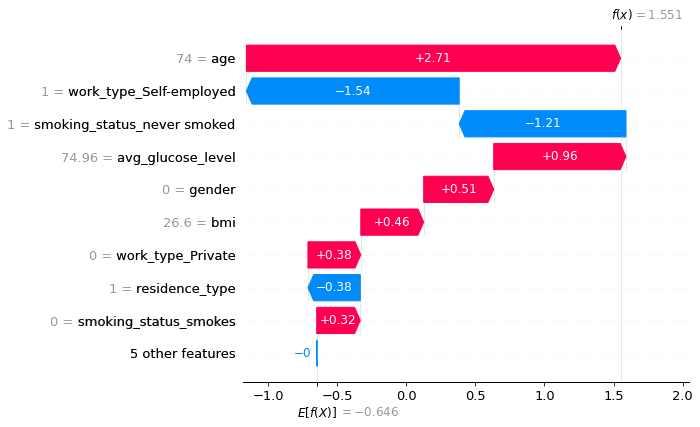

In [44]:
import shap
explainer = shap.Explainer(classifier, X_train)
shap_values = explainer(X_train, check_additivity=False )
shap.plots.waterfall(shap_values[0])

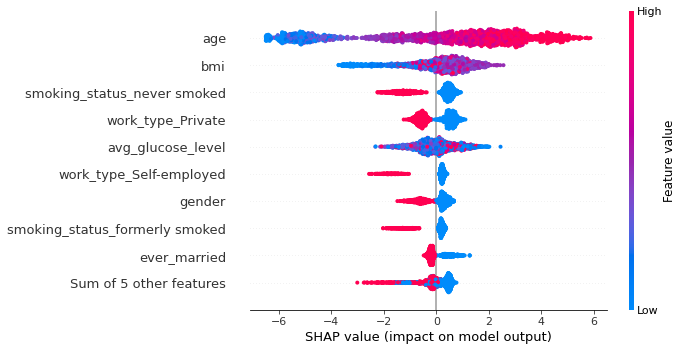

In [45]:
explainer = shap.Explainer(classifier, X_test)
shap_values = explainer(X_test, check_additivity=False )
shap.plots.beeswarm(shap_values)

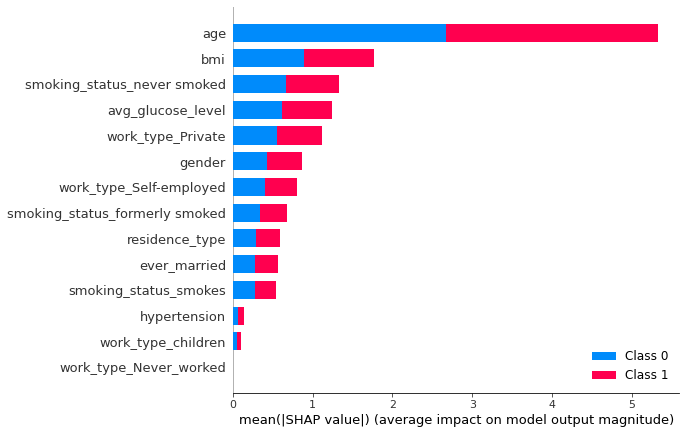

In [46]:

shap_values = shap.TreeExplainer(classifier).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

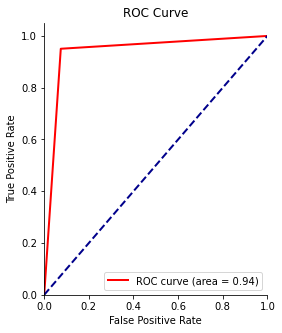

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, tune_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,5))
lw = 2
plt.plot(fpr, tpr, color='red', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()